In [3]:
#Imports - Pybullet
import pybullet as p
import pybullet_data

In [4]:
#Imports - Pytorch
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
import torch.utils.data as Data

import torchvision
from torchvision import transforms
import torchvision.datasets as dst
import torchvision.transforms.functional as TF
from torchvision.utils import save_image, make_grid

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
#Imports - Others
import math
import random
import time
import shutil
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Kuka Arm Environment

In [177]:
#Parameters for kuka
maxVelocity = .35
maxForce = 200.
fingerAForce = 2.5
fingerBForce = 2.5
fingerTipForce = 2.5

kukaEndEffectorIndex = 6
kukaGripperIndex = 7

endEffectorPos = [0.537, 0.0, 0.5]
endEffectorAngle = 0

In [178]:
# Initial state for kuka arm
def resetKukaArm(kukaUid):
    
    
    p.resetBasePositionAndOrientation(kukaUid, [-0.100000, 0.000000, 0.070000],
                                      [0.000000, 0.000000, 0.000000, 1.000000])
    
    jointPositions = [0.006418, 0.413184, -0.011401, -1.589317, 0.005379, 1.137684, -0.006539, 
                  0.000048,-0.299912, 0.000000, -0.000043, 0.299960, 0.000000, -0.000200]
    
    #Set Initial position for gripper
    numJoints = p.getNumJoints(kukaUid)

    #Option 1: 
    for jointIndex in range(numJoints):
        p.resetJointState(kukaUid, jointIndex, jointPositions[jointIndex])
        p.setJointMotorControl2(kukaUid,
                                jointIndex,
                                p.POSITION_CONTROL,
                                targetPosition=jointPositions[jointIndex],
                                force=maxForce)
        
    
    for i in range (50):
        p.stepSimulation()
        #time.sleep(1./240)

In [179]:
#Initial the environment (plane, table and the kuka arm)
def resetEnv():
    #Reset GUI
    p.resetSimulation()

    #p.loadURDF("plane.urdf", [0, 0, -1])

    p.loadURDF("table/table.urdf", 0.5000000, 0.00000, -.820000, 0.000000, 0.000000, 0.0, 1.0)

    #Set Gravity
    p.setGravity(0, 0, -10)
    kukaUid = p.loadSDF("kuka_iiwa/kuka_with_gripper2.sdf")
    kukaUid = kukaUid[0]
    
    #Run reset Function
    resetKukaArm(kukaUid)    
    
    return kukaUid

In [180]:
#Set random object, return real position of the object
def setRandomObject():
    # Set objects
    xpos = 0.4 + 0.25 * random.random()
    ypos = 0 + 0.3 * random.random()
    ang = 3.14 * 0.5 + 3.14 * random.random() /3
    orn = p.getQuaternionFromEuler([0, 0, ang])
    blockUid = p.loadURDF("block.urdf", xpos, ypos, -0.18, orn[0], orn[1], orn[2], orn[3])

    #small, kuka cannot hold
    #blockUid = p.loadURDF("cube_small.urdf", xpos, ypos, -0.18, orn[0], orn[1], orn[2], orn[3]) 

    #print(xpos, ypos, "-0.18", orn)
    
    #Let the object fall for a while
    for i in range (10):
        p.stepSimulation()
    
    #get object position and orientation
    blockPos, blockOrn = p.getBasePositionAndOrientation(blockUid)
    blockEuler = p.getEulerFromQuaternion(blockOrn)
#     print('blockPos', blockPos)
#     print('blockOrn', blockEuler)
    
    return blockUid, blockPos, blockEuler

In [181]:
# Function: return dx, dy, dz, calculate how much to move to approach the object
def getAction(kukaUid, blockUid):
    kukaEndEffectorIndex = 6

    blockPos, blockOrn = p.getBasePositionAndOrientation(blockUid)
    #print('blockPos', blockPos)
    
    state = p.getLinkState(kukaUid, kukaEndEffectorIndex)
    actualEndEffectorPos = state[0]
    gripper_len = actualEndEffectorPos[2] - p.getLinkState(kukaUid, 13)[0][2]
    
    dx = blockPos[0] - actualEndEffectorPos[0]
    dy = blockPos[1] - actualEndEffectorPos[1] - 0.02
    dz = blockPos[2] - actualEndEffectorPos[2] + gripper_len + 0.05
    
    return dx, dy, dz

In [182]:
#Apply action to move the end effector to the target position
def moveGripper(kukaUid, dx, dy, dz):
    motorCommands = [dx, dy, dz, 0, 0]
    numJoints = p.getNumJoints(kukaUid)

#     print ("numJoints")
#     print (numJoints)

    useInverseKinematics = 1
    useSimulation = 1
    useNullSpace = 21
    useOrientation = 1

    #lower limits for null space
    ll = [-.967, -2, -2.96, 0.19, -2.96, -2.09, -3.05]
    #upper limits for null space
    ul = [.967, 2, 2.96, 2.29, 2.96, 2.09, 3.05]
    #joint ranges for null space
    jr = [5.8, 4, 5.8, 4, 5.8, 4, 6]
    #restposes for null space
    rp = [0, 0, 0, 0.5 * math.pi, 0, -math.pi * 0.5 * 0.66, 0]
    #joint damping coefficents
    jd = [0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 
          0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001]


    dx = motorCommands[0]
    dy = motorCommands[1]
    dz = motorCommands[2]
    da = motorCommands[3]
    fingerAngle = motorCommands[4]

    state = p.getLinkState(kukaUid, kukaEndEffectorIndex)
    actualEndEffectorPos = state[0]
    endEffectorPos = [actualEndEffectorPos[0], actualEndEffectorPos[1], actualEndEffectorPos[2]]

    #print(endEffectorPos)
    
    endEffectorPos[0] = endEffectorPos[0] + dx
    endEffectorPos[1] = endEffectorPos[1] + dy
    endEffectorPos[2] = endEffectorPos[2] + dz
    # endEffectorAngle = endEffectorAngle + da

    pos = endEffectorPos
    orn = p.getQuaternionFromEuler([0, -math.pi, 0])  # -math.pi,yaw])
    
    #Calculate joint angle using Inverse Kinematics
    jointPoses = p.calculateInverseKinematics(kukaUid,
                                              kukaEndEffectorIndex,
                                              pos,
                                              orn,
                                              jointDamping=jd) #jointDamping关节阻尼
    #Set angle to joints
    for i in range(kukaEndEffectorIndex + 1):
        #print(i)
        p.setJointMotorControl2(bodyUniqueId=kukaUid,
                                jointIndex=i,
                                controlMode=p.POSITION_CONTROL,
                                targetPosition=jointPoses[i],
                                targetVelocity=0,
                                force=maxForce,
                                maxVelocity=maxVelocity,
                                positionGain=0.3,
                                velocityGain=1)
    
    for i in range (1000):
        p.stepSimulation()
        #time.sleep(1./240)

In [183]:
#Grasp, close the fingers
def attmptGrasp(kukaUid):
    finger_angle = 0.3
    endEffectorAngle = 0
    fingerAngle = 0
    for _ in range(500):
        #fingers
        p.setJointMotorControl2(kukaUid,
                                7,
                                p.POSITION_CONTROL,
                                targetPosition=endEffectorAngle,
                                force=maxForce)
        p.setJointMotorControl2(kukaUid,
                                8,
                                p.POSITION_CONTROL,
                                targetPosition=-fingerAngle,
                                force=fingerAForce)
        p.setJointMotorControl2(kukaUid,
                                11,
                                p.POSITION_CONTROL,
                                targetPosition=fingerAngle,
                                force=fingerBForce)

        p.setJointMotorControl2(kukaUid,
                                10,
                                p.POSITION_CONTROL,
                                targetPosition=0,
                                force=fingerTipForce)
        p.setJointMotorControl2(kukaUid,
                                13,
                                p.POSITION_CONTROL,
                                targetPosition=0,
                                force=fingerTipForce)
        p.stepSimulation()
        #time.sleep(timeStep)
        
        finger_angle -= 0.3 / 100.
        if finger_angle < 0:
            finger_angle = 0

In [184]:
#Retract the object to a random position
def retractObjetc(kukaUid):
    kukaEndEffectorIndex = 6
    orn = p.getQuaternionFromEuler([0, -math.pi, 0])
    xpos = 0.15 + 0.3 * random.random()
    ypos = 0.1 + 0.3 * random.random()
    pos = [xpos, ypos, 0.5]
    
    jd = [0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 
          0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001]
    
    jointPoses = p.calculateInverseKinematics(kukaUid,
                                              kukaEndEffectorIndex,
                                              pos,
                                              orn,
                                              jointDamping=jd) #jointDamping关节阻尼

    for i in range(kukaEndEffectorIndex + 1):
        #print(i)
        p.setJointMotorControl2(bodyUniqueId=kukaUid,
                                jointIndex=i,
                                controlMode=p.POSITION_CONTROL,
                                targetPosition=jointPoses[i],
                                targetVelocity=0,
                                force=maxForce,
                                maxVelocity=maxVelocity,
                                positionGain=0.3,
                                velocityGain=1)
    
    for i in range (1000):
        p.stepSimulation()
        #time.sleep(1./240)

In [185]:
#render， getCameraImage suitable for all states
def render(kukaUid, blockUid, cam_dist, cam_yaw, cam_pitch, camPos):
    
    RENDER_HEIGHT = 64
    RENDER_WIDTH = 64
    
#     camPos = (0.525, 0.15, -0.186)
    #cam_dist = 1.0
#     cam_yaw = 180
#     cam_pitch = -40

    #base_pos, orn = p.getBasePositionAndOrientation(kukaUid)
    #base_pos: (-0.1, 0, 0.07)
    
    blockPos, _ = p.getBasePositionAndOrientation(blockUid)
    
    view_matrix = p.computeViewMatrixFromYawPitchRoll(cameraTargetPosition = blockPos,
                                                      distance = cam_dist,
                                                      yaw = cam_yaw,
                                                      pitch = cam_pitch,
                                                      roll = 0,
                                                      upAxisIndex = 2)

    proj_matrix = p.computeProjectionMatrixFOV(fov=60,
                                               aspect=float(RENDER_WIDTH) / RENDER_HEIGHT,
                                               nearVal=0.1,
                                               farVal=100.0)

    (_, _, rgb_px, depth_px, _) = p.getCameraImage(width=RENDER_WIDTH,
                                                   height=RENDER_HEIGHT,
                                                   viewMatrix=view_matrix,
                                                   projectionMatrix=proj_matrix,
                                                   renderer=p.ER_BULLET_HARDWARE_OPENGL)
                                                   #renderer=p.ER_TINY_RENDERER #Direct mode)
    
    # Get and save the rgb and depth arrays
    rgb_array = np.array(rgb_px, dtype=np.uint8)
    rgb_array = np.reshape(rgb_array, (RENDER_HEIGHT, RENDER_WIDTH, 4))
    rgb_array = rgb_array[:, :, :3]

    depth_array = np.array(depth_px)
    
    return rgb_array, depth_array

# Data Generate Pipeline

## Testing and Debug
This part is used to test and debug the data process pipeline.

In [13]:
#Test debug
p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.resetDebugVisualizerCamera(
    cameraDistance = 2.5, 
    cameraYaw = 180, #左右仰角
    cameraPitch = -42, #上下仰角 
    cameraTargetPosition = [0.52, -0.2, -0.33]#Camara focus position, on gripper
)

In [14]:
kukaUid = resetEnv()
blockUid, blockPos, blockEuler = setRandomObject()

In [15]:
p.getLinkState(kukaUid, 6)

((0.5320830254779826, -0.0011177858192709432, 0.4762984342958597),
 (-0.0001292978741070165,
  0.9999997215808589,
  0.0001509164667874984,
  0.0007192666295375219),
 (0.0, 0.0, 0.02),
 (0.0, 0.0, 0.0, 1.0),
 (0.5320542454719543, -0.0011238261358812451, 0.4962984025478363),
 (-0.00012929787044413388,
  0.9999997615814209,
  0.00015091648674570024,
  0.0007192666525952518))

In [15]:
rgb_array1_initial, depth_array1_initial = render(kukaUid, blockUid, 1, 0, -50, (0.525, 0.15, -0.186))
rgb_array2_initial, depth_array2_initial = render(kukaUid, blockUid, 1, 45, -50, (0.525, 0.15, -0.186))
rgb_array3_initial, depth_array3_initial = render(kukaUid, blockUid, 1, 90, -50, (0.525, 0.15, -0.186))
rgb_array4_initial, depth_array4_initial = render(kukaUid, blockUid, 1, 135, -50, (0.525, 0.15, -0.186))
rgb_array5_initial, depth_array5_initial = render(kukaUid, blockUid, 1, 180, -50, (0.525, 0.15, -0.186))
rgb_array6_initial, depth_array6_initial = render(kukaUid, blockUid, 1, 225, -50, (0.525, 0.15, -0.186))
rgb_array7_initial, depth_array7_initial = render(kukaUid, blockUid, 0.8, 270, -50, (0.525, 0.15, -0.186))

In [ ]:
#Get relative position between the arm endeffector and object, AKA the action
dx, dy, dz = getAction(kukaUid, blockUid)
#print(dx,dy,dz)

#
#Approach
moveGripper(kukaUid, dx, dy, dz)

In [15]:
rgb_array1_appro, depth_array1_appro = render(kukaUid, blockUid, 1, 0, -50, (0.525, 0.15, -0.186))
rgb_array2_appro, depth_array2_appro = render(kukaUid, blockUid, 1, 45, -50, (0.525, 0.15, -0.186))
rgb_array3_appro, depth_array3_appro = render(kukaUid, blockUid, 1, 90, -50, (0.525, 0.15, -0.186))
rgb_array4_appro, depth_array4_appro = render(kukaUid, blockUid, 1, 135, -50, (0.525, 0.15, -0.186))
rgb_array5_appro, depth_array5_appro = render(kukaUid, blockUid, 1, 180, -50, (0.525, 0.15, -0.186))
rgb_array6_appro, depth_array6_appro = render(kukaUid, blockUid, 1, 225, -50, (0.525, 0.15, -0.186))
rgb_array7_appro, depth_array7_appro = render(kukaUid, blockUid, 0.8, 270, -50, (0.525, 0.15, -0.186))

In [16]:
attmptGrasp(kukaUid)

In [20]:
rgb_array1_grasp, depth_array1_grasp = render(kukaUid, blockUid, 1, 0, -50, (0.525, 0.15, -0.186))
rgb_array2_grasp, depth_array2_grasp = render(kukaUid, blockUid, 1, 45, -50, (0.525, 0.15, -0.186))
rgb_array3_grasp, depth_array3_grasp = render(kukaUid, blockUid, 1, 90, -50, (0.525, 0.15, -0.186))
rgb_array4_grasp, depth_array4_grasp = render(kukaUid, blockUid, 1, 135, -50, (0.525, 0.15, -0.186))
rgb_array5_grasp, depth_array5_grasp = render(kukaUid, blockUid, 1, 180, -50, (0.525, 0.15, -0.186))
rgb_array6_grasp, depth_array6_grasp = render(kukaUid, blockUid, 1, 225, -50, (0.525, 0.15, -0.186))
rgb_array7_grasp, depth_array7_grasp = render(kukaUid, blockUid, 0.8, 270, -50, (0.525, 0.15, -0.186))

In [21]:
retractObjetc(kukaUid)

In [25]:
rgb_array1_retract, depth_array1_retract = render(kukaUid, blockUid, 0.8, 0, -50, (0.3, 0.25, 0.5))
rgb_array2_retract, depth_array2_retract = render(kukaUid, blockUid, 0.8, 45, -50, (0.3, 0.25, 0.5))
rgb_array3_retract, depth_array3_retract = render(kukaUid, blockUid, 0.8, 90, -50, (0.3, 0.25, 0.5))
rgb_array4_retract, depth_array4_retract = render(kukaUid, blockUid, 0.8, 135, -50, (0.3, 0.25, 0.5))
rgb_array5_retract, depth_array5_retract = render(kukaUid, blockUid, 0.8, 180, -50, (0.3, 0.25, 0.5))
rgb_array6_retract, depth_array6_retract = render(kukaUid, blockUid, 0.8, 225, -50, (0.3, 0.25, 0.5))
rgb_array7_retract, depth_array7_retract = render(kukaUid, blockUid, 0.8, 270, -50, (0.3, 0.25, 0.5))

## Generating images
This part is used to get the training images, and get the end effector states information.

In [13]:
#Initializing GUI
p.connect(p.DIRECT)
# p.connect(p.GUI)

p.setAdditionalSearchPath(pybullet_data.getDataPath())

In [15]:
#Set Camera angles
p.resetDebugVisualizerCamera(
    cameraDistance = 2.5, 
    cameraYaw = 180, #左右仰角
    cameraPitch = -42, #上下仰角 
    cameraTargetPosition = [0.52, -0.2, -0.33]#Camara focus position, on gripper
)

In [16]:
# This is the pipeline to get the images and endeffector states.
# This pipeline will save the images, image arrays, and end effector state arrays.
# This pipeline will run 2000 attempts of grasp, filter failed grasps.
rgb_array_list_initial_ori1 = []
rgb_array_list_initial_ori2 = []
rgb_array_list_initial_ori3 = []
rgb_array_list_initial_ori4 = []
rgb_array_list_initial_ori5 = []
rgb_array_list_initial_ori6 = []
rgb_array_list_initial_ori7 = []
depth_array_list_initial_ori1 = []
depth_array_list_initial_ori2 = []
depth_array_list_initial_ori3 = []
depth_array_list_initial_ori4 = []
depth_array_list_initial_ori5 = []
depth_array_list_initial_ori6 = []
depth_array_list_initial_ori7 = []
endEffeStates_list_initial = []
objectStates_list_initial = []

rgb_array_list_appro_ori1 = []
rgb_array_list_appro_ori2 = []
rgb_array_list_appro_ori3 = []
rgb_array_list_appro_ori4 = []
rgb_array_list_appro_ori5 = []
rgb_array_list_appro_ori6 = []
rgb_array_list_appro_ori7 = []
depth_array_list_appro_ori1 = []
depth_array_list_appro_ori2 = []
depth_array_list_appro_ori3 = []
depth_array_list_appro_ori4 = []
depth_array_list_appro_ori5 = []
depth_array_list_appro_ori6 = []
depth_array_list_appro_ori7 = []
endEffeStates_list_appro = []
objectStates_list_appro = []

rgb_array_list_grasp_ori1 = []
rgb_array_list_grasp_ori2 = []
rgb_array_list_grasp_ori3 = []
rgb_array_list_grasp_ori4 = []
rgb_array_list_grasp_ori5 = []
rgb_array_list_grasp_ori6 = []
rgb_array_list_grasp_ori7 = []
depth_array_list_grasp_ori1 = []
depth_array_list_grasp_ori2 = []
depth_array_list_grasp_ori3 = []
depth_array_list_grasp_ori4 = []
depth_array_list_grasp_ori5 = []
depth_array_list_grasp_ori6 = []
depth_array_list_grasp_ori7 = []
endEffeStates_list_grasp = []
objectStates_list_grasp = []

rgb_array_list_retract_ori1 = []
rgb_array_list_retract_ori2 = []
rgb_array_list_retract_ori3 = []
rgb_array_list_retract_ori4 = []
rgb_array_list_retract_ori5 = []
rgb_array_list_retract_ori6 = []
rgb_array_list_retract_ori7 = []
depth_array_list_retract_ori1 = []
depth_array_list_retract_ori2 = []
depth_array_list_retract_ori3 = []
depth_array_list_retract_ori4 = []
depth_array_list_retract_ori5 = []
depth_array_list_retract_ori6 = []
depth_array_list_retract_ori7 = []
endEffeStates_list_retract = []
objectStates_list_retract = []

for i in range(2000):
    
    kukaUid = resetEnv()
    blockUid, blockPos, blockEuler = setRandomObject()
    
    rgb_array1_initial, depth_array1_initial = render(kukaUid, blockUid, 1, 0, -50, (0.525, 0.15, -0.186))
    rgb_array2_initial, depth_array2_initial = render(kukaUid, blockUid, 1, 45, -50, (0.525, 0.15, -0.186))
    rgb_array3_initial, depth_array3_initial = render(kukaUid, blockUid, 1, 90, -50, (0.525, 0.15, -0.186))
    rgb_array4_initial, depth_array4_initial = render(kukaUid, blockUid, 1, 135, -50, (0.525, 0.15, -0.186))
    rgb_array5_initial, depth_array5_initial = render(kukaUid, blockUid, 1, 180, -50, (0.525, 0.15, -0.186))
    rgb_array6_initial, depth_array6_initial = render(kukaUid, blockUid, 1, 225, -50, (0.525, 0.15, -0.186))
    rgb_array7_initial, depth_array7_initial = render(kukaUid, blockUid, 0.8, 270, -50, (0.525, 0.15, -0.186))
    
    endEffState_initial = p.getLinkState(kukaUid, 6)
    objectState_initial = p.getBasePositionAndOrientation(blockUid)

    #Get relative position between the arm endeffector and object, AKA the action
    dx, dy, dz = getAction(kukaUid, blockUid)
    #print(dx,dy,dz)
    
    #
    #Approach
    moveGripper(kukaUid, dx, dy, dz)
    
    rgb_array1_appro, depth_array1_appro = render(kukaUid, blockUid, 1, 0, -50, (0.525, 0.15, -0.186))
    rgb_array2_appro, depth_array2_appro = render(kukaUid, blockUid, 1, 45, -50, (0.525, 0.15, -0.186))
    rgb_array3_appro, depth_array3_appro = render(kukaUid, blockUid, 1, 90, -50, (0.525, 0.15, -0.186))
    rgb_array4_appro, depth_array4_appro = render(kukaUid, blockUid, 1, 135, -50, (0.525, 0.15, -0.186))
    rgb_array5_appro, depth_array5_appro = render(kukaUid, blockUid, 1, 180, -50, (0.525, 0.15, -0.186))
    rgb_array6_appro, depth_array6_appro = render(kukaUid, blockUid, 1, 225, -50, (0.525, 0.15, -0.186))
    rgb_array7_appro, depth_array7_appro = render(kukaUid, blockUid, 0.8, 270, -50, (0.525, 0.15, -0.186))

    endEffState_appro = p.getLinkState(kukaUid, 6)
    objectState_appro = p.getBasePositionAndOrientation(blockUid)
    
    
    #
    #Grasp
    attmptGrasp(kukaUid)
    
    rgb_array1_grasp, depth_array1_grasp = render(kukaUid, blockUid, 1, 0, -50, (0.525, 0.15, -0.186))
    rgb_array2_grasp, depth_array2_grasp = render(kukaUid, blockUid, 1, 45, -50, (0.525, 0.15, -0.186))
    rgb_array3_grasp, depth_array3_grasp = render(kukaUid, blockUid, 1, 90, -50, (0.525, 0.15, -0.186))
    rgb_array4_grasp, depth_array4_grasp = render(kukaUid, blockUid, 1, 135, -50, (0.525, 0.15, -0.186))
    rgb_array5_grasp, depth_array5_grasp = render(kukaUid, blockUid, 1, 180, -50, (0.525, 0.15, -0.186))
    rgb_array6_grasp, depth_array6_grasp = render(kukaUid, blockUid, 1, 225, -50, (0.525, 0.15, -0.186))
    rgb_array7_grasp, depth_array7_grasp = render(kukaUid, blockUid, 0.8, 270, -50, (0.525, 0.15, -0.186))

    endEffState_grasp = p.getLinkState(kukaUid, 6)
    objectState_grasp = p.getBasePositionAndOrientation(blockUid)
    
    
    #
    #Retract
    retractObjetc(kukaUid)
    
    rgb_array1_retract, depth_array1_retract = render(kukaUid, blockUid, 0.8, 0, -50, (0.3, 0.25, 0.5))
    rgb_array2_retract, depth_array2_retract = render(kukaUid, blockUid, 0.8, 45, -50, (0.3, 0.25, 0.5))
    rgb_array3_retract, depth_array3_retract = render(kukaUid, blockUid, 0.8, 90, -50, (0.3, 0.25, 0.5))
    rgb_array4_retract, depth_array4_retract = render(kukaUid, blockUid, 0.8, 135, -50, (0.3, 0.25, 0.5))
    rgb_array5_retract, depth_array5_retract = render(kukaUid, blockUid, 0.8, 180, -50, (0.3, 0.25, 0.5))
    rgb_array6_retract, depth_array6_retract = render(kukaUid, blockUid, 0.8, 225, -50, (0.3, 0.25, 0.5))
    rgb_array7_retract, depth_array7_retract = render(kukaUid, blockUid, 0.8, 270, -50, (0.3, 0.25, 0.5))

    endEffState_retract = p.getLinkState(kukaUid, 6)
    objectState_retract = p.getBasePositionAndOrientation(blockUid)
    
    #Save only when sucess
    if objectState_retract[0][2] > -0.1:
        print("Approach ", i, 'sucess.')
        
        #
        #Initial States
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/initial_' + str(i) + '_ori1' +'.png', rgb_array1_initial)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/initial_' + str(i) + '_ori2' +'.png', rgb_array2_initial)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/initial_' + str(i) + '_ori3' +'.png', rgb_array3_initial)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/initial_' + str(i) + '_ori4' +'.png', rgb_array4_initial)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/initial_' + str(i) + '_ori5' +'.png', rgb_array5_initial)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/initial_' + str(i) + '_ori6' +'.png', rgb_array6_initial)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/initial_' + str(i) + '_ori7' +'.png', rgb_array7_initial)

        rgb_array_list_initial_ori1.append(rgb_array1_initial)
        rgb_array_list_initial_ori2.append(rgb_array2_initial)
        rgb_array_list_initial_ori3.append(rgb_array3_initial)
        rgb_array_list_initial_ori4.append(rgb_array4_initial)
        rgb_array_list_initial_ori5.append(rgb_array5_initial)
        rgb_array_list_initial_ori6.append(rgb_array6_initial)
        rgb_array_list_initial_ori7.append(rgb_array7_initial)

        depth_array_list_initial_ori1.append(depth_array1_initial)
        depth_array_list_initial_ori2.append(depth_array2_initial)
        depth_array_list_initial_ori3.append(depth_array3_initial)
        depth_array_list_initial_ori4.append(depth_array4_initial)
        depth_array_list_initial_ori5.append(depth_array5_initial)
        depth_array_list_initial_ori6.append(depth_array6_initial)
        depth_array_list_initial_ori7.append(depth_array7_initial)
        
        endEffeStates_list_initial.append(endEffState_initial)
        objectStates_list_initial.append(objectState_initial)
        
        #
        #Approach
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/appro_' + str(i) + '_ori1' +'.png', rgb_array1_appro)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/appro_' + str(i) + '_ori2' +'.png', rgb_array2_appro)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/appro_' + str(i) + '_ori3' +'.png', rgb_array3_appro)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/appro_' + str(i) + '_ori4' +'.png', rgb_array4_appro)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/appro_' + str(i) + '_ori5' +'.png', rgb_array5_appro)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/appro_' + str(i) + '_ori6' +'.png', rgb_array6_appro)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/appro_' + str(i) + '_ori7' +'.png', rgb_array7_appro)

        rgb_array_list_appro_ori1.append(rgb_array1_appro)
        rgb_array_list_appro_ori2.append(rgb_array2_appro)
        rgb_array_list_appro_ori3.append(rgb_array3_appro)
        rgb_array_list_appro_ori4.append(rgb_array4_appro)
        rgb_array_list_appro_ori5.append(rgb_array5_appro)
        rgb_array_list_appro_ori6.append(rgb_array6_appro)
        rgb_array_list_appro_ori7.append(rgb_array7_appro)

        depth_array_list_appro_ori1.append(depth_array1_appro)
        depth_array_list_appro_ori2.append(depth_array2_appro)
        depth_array_list_appro_ori3.append(depth_array3_appro)
        depth_array_list_appro_ori4.append(depth_array4_appro)
        depth_array_list_appro_ori5.append(depth_array5_appro)
        depth_array_list_appro_ori6.append(depth_array6_appro)
        depth_array_list_appro_ori7.append(depth_array7_appro)
        
        endEffeStates_list_appro.append(endEffState_appro)
        objectStates_list_appro.append(objectState_appro)

        #
        #Grasp
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/grasp_' + str(i) + '_ori1' +'.png', rgb_array1_grasp)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/grasp_' + str(i) + '_ori2' +'.png', rgb_array2_grasp)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/grasp_' + str(i) + '_ori3' +'.png', rgb_array3_grasp)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/grasp_' + str(i) + '_ori4' +'.png', rgb_array4_grasp)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/grasp_' + str(i) + '_ori5' +'.png', rgb_array5_grasp)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/grasp_' + str(i) + '_ori6' +'.png', rgb_array6_grasp)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/grasp_' + str(i) + '_ori7' +'.png', rgb_array7_grasp)

        rgb_array_list_grasp_ori1.append(rgb_array1_grasp)
        rgb_array_list_grasp_ori2.append(rgb_array2_grasp)
        rgb_array_list_grasp_ori3.append(rgb_array3_grasp)
        rgb_array_list_grasp_ori4.append(rgb_array4_grasp)
        rgb_array_list_grasp_ori5.append(rgb_array5_grasp)
        rgb_array_list_grasp_ori6.append(rgb_array6_grasp)
        rgb_array_list_grasp_ori7.append(rgb_array7_grasp)

        depth_array_list_grasp_ori1.append(depth_array1_grasp)
        depth_array_list_grasp_ori2.append(depth_array2_grasp)
        depth_array_list_grasp_ori3.append(depth_array3_grasp)
        depth_array_list_grasp_ori4.append(depth_array4_grasp)
        depth_array_list_grasp_ori5.append(depth_array5_grasp)
        depth_array_list_grasp_ori6.append(depth_array6_grasp)
        depth_array_list_grasp_ori7.append(depth_array7_grasp)
        
        endEffeStates_list_grasp.append(endEffState_grasp)
        objectStates_list_grasp.append(objectState_grasp)

        #
        #Retract
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/retract_' + 
                   str(i) + '_ori1' +'.png', rgb_array1_retract)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/retract_' + 
                   str(i) + '_ori2' +'.png', rgb_array2_retract)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/retract_' + 
                   str(i) + '_ori3' +'.png', rgb_array3_retract)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/retract_' + 
                   str(i) + '_ori4' +'.png', rgb_array4_retract)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/retract_' + 
                   str(i) + '_ori5' +'.png', rgb_array5_retract)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/retract_' + 
                   str(i) + '_ori6' +'.png', rgb_array6_retract)
        plt.imsave('/Users/jamesyang/Desktop/generatedImages/retract_' + 
                   str(i) + '_ori7' +'.png', rgb_array7_retract)

        rgb_array_list_retract_ori1.append(rgb_array1_retract)
        rgb_array_list_retract_ori2.append(rgb_array2_retract)
        rgb_array_list_retract_ori3.append(rgb_array3_retract)
        rgb_array_list_retract_ori4.append(rgb_array4_retract)
        rgb_array_list_retract_ori5.append(rgb_array5_retract)
        rgb_array_list_retract_ori6.append(rgb_array6_retract)
        rgb_array_list_retract_ori7.append(rgb_array7_retract)

        depth_array_list_retract_ori1.append(depth_array1_retract)
        depth_array_list_retract_ori2.append(depth_array2_retract)
        depth_array_list_retract_ori3.append(depth_array3_retract)
        depth_array_list_retract_ori4.append(depth_array4_retract)
        depth_array_list_retract_ori5.append(depth_array5_retract)
        depth_array_list_retract_ori6.append(depth_array6_retract)
        depth_array_list_retract_ori7.append(depth_array7_retract)
        
        endEffeStates_list_retract.append(endEffState_retract)
        objectStates_list_retract.append(objectState_retract)
        
    else: 
        print("Approach ", i, 'failed.')

Approach  0 sucess.
Approach  1 sucess.
Approach  2 sucess.
Approach  3 sucess.
Approach  4 failed.
Approach  5 sucess.
Approach  6 failed.
Approach  7 sucess.
Approach  8 sucess.
Approach  9 failed.
Approach  10 failed.
Approach  11 sucess.
Approach  12 sucess.
Approach  13 failed.
Approach  14 failed.
Approach  15 failed.
Approach  16 sucess.
Approach  17 failed.
Approach  18 sucess.
Approach  19 sucess.
Approach  20 sucess.
Approach  21 sucess.
Approach  22 sucess.
Approach  23 sucess.
Approach  24 sucess.
Approach  25 sucess.
Approach  26 sucess.
Approach  27 sucess.
Approach  28 sucess.
Approach  29 sucess.
Approach  30 sucess.
Approach  31 sucess.
Approach  32 sucess.
Approach  33 failed.
Approach  34 sucess.
Approach  35 sucess.
Approach  36 sucess.
Approach  37 failed.
Approach  38 failed.
Approach  39 sucess.
Approach  40 failed.
Approach  41 sucess.
Approach  42 sucess.
Approach  43 sucess.
Approach  44 sucess.
Approach  45 failed.
Approach  46 sucess.
Approach  47 failed.
Ap

Approach  378 sucess.
Approach  379 sucess.
Approach  380 sucess.
Approach  381 sucess.
Approach  382 sucess.
Approach  383 failed.
Approach  384 failed.
Approach  385 failed.
Approach  386 sucess.
Approach  387 failed.
Approach  388 failed.
Approach  389 sucess.
Approach  390 failed.
Approach  391 sucess.
Approach  392 sucess.
Approach  393 failed.
Approach  394 sucess.
Approach  395 failed.
Approach  396 failed.
Approach  397 sucess.
Approach  398 sucess.
Approach  399 failed.
Approach  400 failed.
Approach  401 failed.
Approach  402 sucess.
Approach  403 failed.
Approach  404 sucess.
Approach  405 sucess.
Approach  406 sucess.
Approach  407 sucess.
Approach  408 sucess.
Approach  409 failed.
Approach  410 sucess.
Approach  411 sucess.
Approach  412 failed.
Approach  413 failed.
Approach  414 sucess.
Approach  415 sucess.
Approach  416 sucess.
Approach  417 failed.
Approach  418 failed.
Approach  419 failed.
Approach  420 sucess.
Approach  421 sucess.
Approach  422 sucess.
Approach  

Approach  751 sucess.
Approach  752 sucess.
Approach  753 sucess.
Approach  754 sucess.
Approach  755 failed.
Approach  756 sucess.
Approach  757 sucess.
Approach  758 sucess.
Approach  759 sucess.
Approach  760 sucess.
Approach  761 sucess.
Approach  762 failed.
Approach  763 failed.
Approach  764 failed.
Approach  765 sucess.
Approach  766 sucess.
Approach  767 sucess.
Approach  768 failed.
Approach  769 sucess.
Approach  770 failed.
Approach  771 sucess.
Approach  772 sucess.
Approach  773 failed.
Approach  774 failed.
Approach  775 sucess.
Approach  776 failed.
Approach  777 sucess.
Approach  778 sucess.
Approach  779 sucess.
Approach  780 sucess.
Approach  781 failed.
Approach  782 sucess.
Approach  783 failed.
Approach  784 sucess.
Approach  785 sucess.
Approach  786 sucess.
Approach  787 failed.
Approach  788 sucess.
Approach  789 failed.
Approach  790 sucess.
Approach  791 sucess.
Approach  792 sucess.
Approach  793 sucess.
Approach  794 failed.
Approach  795 sucess.
Approach  

Approach  1119 sucess.
Approach  1120 failed.
Approach  1121 sucess.
Approach  1122 sucess.
Approach  1123 sucess.
Approach  1124 failed.
Approach  1125 failed.
Approach  1126 sucess.
Approach  1127 failed.
Approach  1128 sucess.
Approach  1129 sucess.
Approach  1130 sucess.
Approach  1131 sucess.
Approach  1132 sucess.
Approach  1133 failed.
Approach  1134 sucess.
Approach  1135 failed.
Approach  1136 sucess.
Approach  1137 failed.
Approach  1138 failed.
Approach  1139 failed.
Approach  1140 sucess.
Approach  1141 sucess.
Approach  1142 failed.
Approach  1143 sucess.
Approach  1144 sucess.
Approach  1145 failed.
Approach  1146 sucess.
Approach  1147 sucess.
Approach  1148 sucess.
Approach  1149 sucess.
Approach  1150 failed.
Approach  1151 sucess.
Approach  1152 failed.
Approach  1153 sucess.
Approach  1154 sucess.
Approach  1155 sucess.
Approach  1156 failed.
Approach  1157 sucess.
Approach  1158 failed.
Approach  1159 sucess.
Approach  1160 sucess.
Approach  1161 failed.
Approach  1

Approach  1476 sucess.
Approach  1477 sucess.
Approach  1478 sucess.
Approach  1479 failed.
Approach  1480 sucess.
Approach  1481 failed.
Approach  1482 sucess.
Approach  1483 sucess.
Approach  1484 sucess.
Approach  1485 sucess.
Approach  1486 sucess.
Approach  1487 sucess.
Approach  1488 sucess.
Approach  1489 sucess.
Approach  1490 sucess.
Approach  1491 sucess.
Approach  1492 sucess.
Approach  1493 sucess.
Approach  1494 sucess.
Approach  1495 sucess.
Approach  1496 sucess.
Approach  1497 sucess.
Approach  1498 sucess.
Approach  1499 sucess.
Approach  1500 sucess.
Approach  1501 sucess.
Approach  1502 sucess.
Approach  1503 failed.
Approach  1504 failed.
Approach  1505 sucess.
Approach  1506 sucess.
Approach  1507 failed.
Approach  1508 sucess.
Approach  1509 sucess.
Approach  1510 sucess.
Approach  1511 sucess.
Approach  1512 sucess.
Approach  1513 sucess.
Approach  1514 sucess.
Approach  1515 sucess.
Approach  1516 sucess.
Approach  1517 sucess.
Approach  1518 sucess.
Approach  1

Approach  1833 failed.
Approach  1834 failed.
Approach  1835 sucess.
Approach  1836 sucess.
Approach  1837 failed.
Approach  1838 failed.
Approach  1839 failed.
Approach  1840 sucess.
Approach  1841 sucess.
Approach  1842 failed.
Approach  1843 sucess.
Approach  1844 failed.
Approach  1845 sucess.
Approach  1846 failed.
Approach  1847 sucess.
Approach  1848 failed.
Approach  1849 failed.
Approach  1850 failed.
Approach  1851 sucess.
Approach  1852 sucess.
Approach  1853 sucess.
Approach  1854 failed.
Approach  1855 sucess.
Approach  1856 sucess.
Approach  1857 sucess.
Approach  1858 sucess.
Approach  1859 failed.
Approach  1860 failed.
Approach  1861 sucess.
Approach  1862 sucess.
Approach  1863 sucess.
Approach  1864 sucess.
Approach  1865 sucess.
Approach  1866 failed.
Approach  1867 sucess.
Approach  1868 sucess.
Approach  1869 sucess.
Approach  1870 sucess.
Approach  1871 sucess.
Approach  1872 failed.
Approach  1873 sucess.
Approach  1874 sucess.
Approach  1875 sucess.
Approach  1

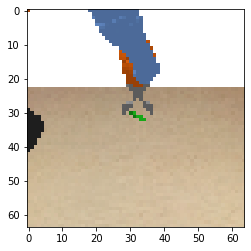

In [17]:
#See the generate images
plt.imshow(rgb_array_list_appro_ori1[6])

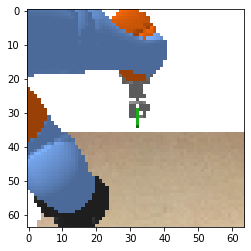

In [18]:
plt.imshow(rgb_array_list_retract_ori1[1000])

In [19]:
sucessNum = len(rgb_array_list_appro_ori1)
sucessRate = sucessNum/2000
print('sucessRate:', sucessRate)

sucessRate: 0.6965


## Save Images and States

In [20]:
# Save arrays to local
#
#Initial states
np.save("rgb_array_list_initial_ori1", np.array(rgb_array_list_initial_ori1))
np.save("rgb_array_list_initial_ori2", np.array(rgb_array_list_initial_ori2))
np.save("rgb_array_list_initial_ori3", np.array(rgb_array_list_initial_ori3))
np.save("rgb_array_list_initial_ori4", np.array(rgb_array_list_initial_ori4))
np.save("rgb_array_list_initial_ori5", np.array(rgb_array_list_initial_ori5))
np.save("rgb_array_list_initial_ori6", np.array(rgb_array_list_initial_ori6))
np.save("rgb_array_list_initial_ori7", np.array(rgb_array_list_initial_ori7))

np.save("depth_array_list_initial_ori1", np.array(depth_array_list_initial_ori1))
np.save("depth_array_list_initial_ori2", np.array(depth_array_list_initial_ori2))
np.save("depth_array_list_initial_ori3", np.array(depth_array_list_initial_ori3))
np.save("depth_array_list_initial_ori4", np.array(depth_array_list_initial_ori4))
np.save("depth_array_list_initial_ori5", np.array(depth_array_list_initial_ori5))
np.save("depth_array_list_initial_ori6", np.array(depth_array_list_initial_ori6))
np.save("depth_array_list_initial_ori7", np.array(depth_array_list_initial_ori7))

np.save("endEffeStates_list_initial.npy", np.array(endEffeStates_list_initial, dtype=object))
np.save("objectStates_list_initial.npy", np.array(objectStates_list_initial, dtype=object))

#
#Appro
np.save("rgb_array_list_appro_ori1", np.array(rgb_array_list_appro_ori1))
np.save("rgb_array_list_appro_ori2", np.array(rgb_array_list_appro_ori2))
np.save("rgb_array_list_appro_ori3", np.array(rgb_array_list_appro_ori3))
np.save("rgb_array_list_appro_ori4", np.array(rgb_array_list_appro_ori4))
np.save("rgb_array_list_appro_ori5", np.array(rgb_array_list_appro_ori5))
np.save("rgb_array_list_appro_ori6", np.array(rgb_array_list_appro_ori6))
np.save("rgb_array_list_appro_ori7", np.array(rgb_array_list_appro_ori7))

np.save("depth_array_list_appro_ori1", np.array(depth_array_list_appro_ori1))
np.save("depth_array_list_appro_ori2", np.array(depth_array_list_appro_ori2))
np.save("depth_array_list_appro_ori3", np.array(depth_array_list_appro_ori3))
np.save("depth_array_list_appro_ori4", np.array(depth_array_list_appro_ori4))
np.save("depth_array_list_appro_ori5", np.array(depth_array_list_appro_ori5))
np.save("depth_array_list_appro_ori6", np.array(depth_array_list_appro_ori6))
np.save("depth_array_list_appro_ori7", np.array(depth_array_list_appro_ori7))

np.save("endEffeStates_list_appro.npy", np.array(endEffeStates_list_appro, dtype=object))
np.save("objectStates_list_appro.npy", np.array(objectStates_list_appro, dtype=object))

#
#Grasp
np.save("rgb_array_list_grasp_ori1", np.array(rgb_array_list_grasp_ori1))
np.save("rgb_array_list_grasp_ori2", np.array(rgb_array_list_grasp_ori2))
np.save("rgb_array_list_grasp_ori3", np.array(rgb_array_list_grasp_ori3))
np.save("rgb_array_list_grasp_ori4", np.array(rgb_array_list_grasp_ori4))
np.save("rgb_array_list_grasp_ori5", np.array(rgb_array_list_grasp_ori5))
np.save("rgb_array_list_grasp_ori6", np.array(rgb_array_list_grasp_ori6))
np.save("rgb_array_list_grasp_ori7", np.array(rgb_array_list_grasp_ori7))

np.save("depth_array_list_grasp_ori1", np.array(depth_array_list_grasp_ori1))
np.save("depth_array_list_grasp_ori2", np.array(depth_array_list_grasp_ori2))
np.save("depth_array_list_grasp_ori3", np.array(depth_array_list_grasp_ori3))
np.save("depth_array_list_grasp_ori4", np.array(depth_array_list_grasp_ori4))
np.save("depth_array_list_grasp_ori5", np.array(depth_array_list_grasp_ori5))
np.save("depth_array_list_grasp_ori6", np.array(depth_array_list_grasp_ori6))
np.save("depth_array_list_grasp_ori7", np.array(depth_array_list_grasp_ori7))

np.save("endEffeStates_list_grasp.npy", np.array(endEffeStates_list_grasp, dtype=object))
np.save("objectStates_list_grasp.npy", np.array(objectStates_list_grasp, dtype=object))

#
#Retract
np.save("rgb_array_list_retract_ori1", np.array(rgb_array_list_retract_ori1))
np.save("rgb_array_list_retract_ori2", np.array(rgb_array_list_retract_ori2))
np.save("rgb_array_list_retract_ori3", np.array(rgb_array_list_retract_ori3))
np.save("rgb_array_list_retract_ori4", np.array(rgb_array_list_retract_ori4))
np.save("rgb_array_list_retract_ori5", np.array(rgb_array_list_retract_ori5))
np.save("rgb_array_list_retract_ori6", np.array(rgb_array_list_retract_ori6))
np.save("rgb_array_list_retract_ori7", np.array(rgb_array_list_retract_ori7))

np.save("depth_array_list_retract_ori1", np.array(depth_array_list_retract_ori1))
np.save("depth_array_list_retract_ori2", np.array(depth_array_list_retract_ori2))
np.save("depth_array_list_retract_ori3", np.array(depth_array_list_retract_ori3))
np.save("depth_array_list_retract_ori4", np.array(depth_array_list_retract_ori4))
np.save("depth_array_list_retract_ori5", np.array(depth_array_list_retract_ori5))
np.save("depth_array_list_retract_ori6", np.array(depth_array_list_retract_ori6))
np.save("depth_array_list_retract_ori7", np.array(depth_array_list_retract_ori7))

np.save("endEffeStates_list_retract.npy", np.array(endEffeStates_list_retract, dtype=object))
np.save("objectStates_list_retract.npy", np.array(objectStates_list_retract, dtype=object))

## Load images and states arrays

In [21]:
# Load arrays saved
#
#Initial
rgb_array_list_initial_ori1_load = np.load("rgb_array_list_initial_ori1.npy")
rgb_array_list_initial_ori2_load = np.load("rgb_array_list_initial_ori2.npy")
rgb_array_list_initial_ori3_load = np.load("rgb_array_list_initial_ori3.npy")
rgb_array_list_initial_ori4_load = np.load("rgb_array_list_initial_ori4.npy")
rgb_array_list_initial_ori5_load = np.load("rgb_array_list_initial_ori5.npy")
rgb_array_list_initial_ori6_load = np.load("rgb_array_list_initial_ori6.npy")
rgb_array_list_initial_ori7_load = np.load("rgb_array_list_initial_ori7.npy")

depth_array_list_initial_ori1_load = np.load("depth_array_list_initial_ori1.npy")
depth_array_list_initial_ori2_load = np.load("depth_array_list_initial_ori2.npy")
depth_array_list_initial_ori3_load = np.load("depth_array_list_initial_ori3.npy")
depth_array_list_initial_ori4_load = np.load("depth_array_list_initial_ori4.npy")
depth_array_list_initial_ori5_load = np.load("depth_array_list_initial_ori5.npy")
depth_array_list_initial_ori6_load = np.load("depth_array_list_initial_ori6.npy")
depth_array_list_initial_ori7_load = np.load("depth_array_list_initial_ori7.npy")

endEffeStates_list_initial_load = np.load("endEffeStates_list_initial.npy", allow_pickle = True)
objectStates_list_initial_load = np.load("objectStates_list_initial.npy", allow_pickle = True)

#
#Appro
rgb_array_list_appro_ori1_load = np.load("rgb_array_list_appro_ori1.npy")
rgb_array_list_appro_ori2_load = np.load("rgb_array_list_appro_ori2.npy")
rgb_array_list_appro_ori3_load = np.load("rgb_array_list_appro_ori3.npy")
rgb_array_list_appro_ori4_load = np.load("rgb_array_list_appro_ori4.npy")
rgb_array_list_appro_ori5_load = np.load("rgb_array_list_appro_ori5.npy")
rgb_array_list_appro_ori6_load = np.load("rgb_array_list_appro_ori6.npy")
rgb_array_list_appro_ori7_load = np.load("rgb_array_list_appro_ori7.npy")

depth_array_list_appro_ori1_load = np.load("depth_array_list_appro_ori1.npy")
depth_array_list_appro_ori2_load = np.load("depth_array_list_appro_ori2.npy")
depth_array_list_appro_ori3_load = np.load("depth_array_list_appro_ori3.npy")
depth_array_list_appro_ori4_load = np.load("depth_array_list_appro_ori4.npy")
depth_array_list_appro_ori5_load = np.load("depth_array_list_appro_ori5.npy")
depth_array_list_appro_ori6_load = np.load("depth_array_list_appro_ori6.npy")
depth_array_list_appro_ori7_load = np.load("depth_array_list_appro_ori7.npy")

endEffeStates_list_appro_load = np.load("endEffeStates_list_appro.npy", allow_pickle = True)
objectStates_list_appro_load = np.load("objectStates_list_appro.npy", allow_pickle = True)

#
#Grasp
rgb_array_list_grasp_ori1_load = np.load("rgb_array_list_grasp_ori1.npy")
rgb_array_list_grasp_ori2_load = np.load("rgb_array_list_grasp_ori2.npy")
rgb_array_list_grasp_ori3_load = np.load("rgb_array_list_grasp_ori3.npy")
rgb_array_list_grasp_ori4_load = np.load("rgb_array_list_grasp_ori4.npy")
rgb_array_list_grasp_ori5_load = np.load("rgb_array_list_grasp_ori5.npy")
rgb_array_list_grasp_ori6_load = np.load("rgb_array_list_grasp_ori6.npy")
rgb_array_list_grasp_ori7_load = np.load("rgb_array_list_grasp_ori7.npy")

depth_array_list_grasp_ori1_load = np.load("depth_array_list_grasp_ori1.npy")
depth_array_list_grasp_ori2_load = np.load("depth_array_list_grasp_ori2.npy")
depth_array_list_grasp_ori3_load = np.load("depth_array_list_grasp_ori3.npy")
depth_array_list_grasp_ori4_load = np.load("depth_array_list_grasp_ori4.npy")
depth_array_list_grasp_ori5_load = np.load("depth_array_list_grasp_ori5.npy")
depth_array_list_grasp_ori6_load = np.load("depth_array_list_grasp_ori6.npy")
depth_array_list_grasp_ori7_load = np.load("depth_array_list_grasp_ori7.npy")

endEffeStates_list_grasp_load = np.load("endEffeStates_list_grasp.npy", allow_pickle = True)
objectStates_list_grasp_load = np.load("objectStates_list_grasp.npy", allow_pickle = True)

#
#Retract
rgb_array_list_retract_ori1_load = np.load("rgb_array_list_retract_ori1.npy")
rgb_array_list_retract_ori2_load = np.load("rgb_array_list_retract_ori2.npy")
rgb_array_list_retract_ori3_load = np.load("rgb_array_list_retract_ori3.npy")
rgb_array_list_retract_ori4_load = np.load("rgb_array_list_retract_ori4.npy")
rgb_array_list_retract_ori5_load = np.load("rgb_array_list_retract_ori5.npy")
rgb_array_list_retract_ori6_load = np.load("rgb_array_list_retract_ori6.npy")
rgb_array_list_retract_ori7_load = np.load("rgb_array_list_retract_ori7.npy")

depth_array_list_retract_ori1_load = np.load("depth_array_list_retract_ori1.npy")
depth_array_list_retract_ori2_load = np.load("depth_array_list_retract_ori2.npy")
depth_array_list_retract_ori3_load = np.load("depth_array_list_retract_ori3.npy")
depth_array_list_retract_ori4_load = np.load("depth_array_list_retract_ori4.npy")
depth_array_list_retract_ori5_load = np.load("depth_array_list_retract_ori5.npy")
depth_array_list_retract_ori6_load = np.load("depth_array_list_retract_ori6.npy")
depth_array_list_retract_ori7_load = np.load("depth_array_list_retract_ori7.npy")

endEffeStates_list_retract_load = np.load("endEffeStates_list_retract.npy", allow_pickle = True)
objectStates_list_retract_load = np.load("objectStates_list_retract.npy", allow_pickle = True)

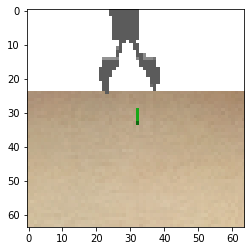

In [22]:
#Show RGB from array
plt.imshow(rgb_array_list_initial_ori1_load[1000])

# VAE

In [4]:
#Check torch and torchvision version
#Need to make sure the torch version is 1.6.0 and the torchvision version is 0.7.0
print('Torch version:', torch.__version__)
print('Torchvision version:', torchvision.__version__)

#If not
# !pip uninstall torch
# !pip uninstall torchvision
# !pip install torchvision==0.7.0
# !pip install torch==1.6.0

Torch version: 1.6.0
Torchvision version: 0.7.0


In [4]:
class VAE(nn.Module):

    def __init__(self, in_channels, latent_dim, hidden_dims = None):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        img_channels = in_channels

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU()
                )
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]* 4 * 4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]* 4 * 4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4 * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU()
                )
            )



        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= img_channels,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())

    def encode(self, input):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z):
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 256, 4, 4) #一层2*2
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self, *args, **kwargs):
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =F.mse_loss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}

    def sample(self, num_samples, current_device):
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples, self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x):
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

## VAE Choose Latent Space Dimension
Part one of VAE, Find the best latent space dimension and image generation method. Training code is in seperate notebook, because the training is proceeded in Google colab.

### Loss for Fixed Camera Img

In [39]:
#Loss for fixed camera target image VAE, latent space dim = 128
fix_128_avg = np.load("VAE_Loss_Fixed/RGB_avg_loss_appro_128.npy")
fix_128_kld = np.load("VAE_Loss_Fixed/RGB_KLD_loss_appro_128.npy")
fix_128_recon = np.load("VAE_Loss_Fixed/RGB_recon_loss_appro_128.npy")

Text(0.5, 1.0, 'Total Loss of Fixed Cam_Img_128')

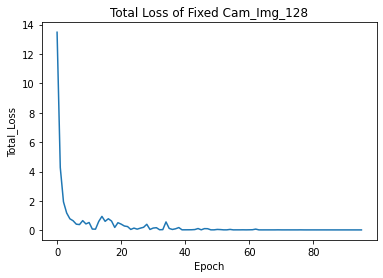

In [40]:
plt.plot(fix_128_avg[4:100])
plt.xlabel("Epoch")
plt.ylabel("Total_Loss")
plt.title("Total Loss of Fixed Cam_Img_128")

Text(0.5, 1.0, 'KLD Loss of Fixed Cam_Img_128')

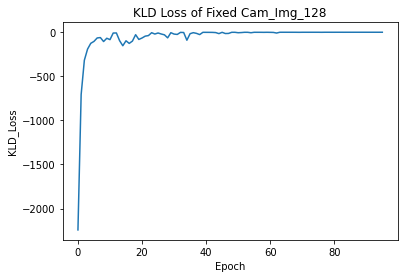

In [41]:
plt.plot(fix_128_kld[4:100])
plt.xlabel("Epoch")
plt.ylabel("KLD_Loss")
plt.title("KLD Loss of Fixed Cam_Img_128")

Text(0.5, 1.0, 'Reconstructed Loss of Fixed Cam_Img_128')

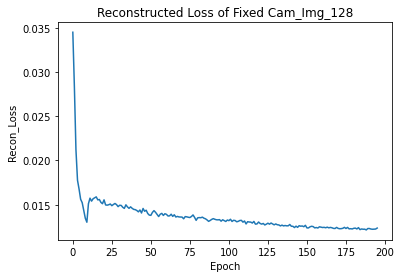

In [45]:
plt.plot(fix_128_recon[4:200])
plt.xlabel("Epoch")
plt.ylabel("Recon_Loss")
plt.title("Reconstructed Loss of Fixed Cam_Img_128")

In [4]:
#Loss for fixed camera target image VAE, latent space dim = 512
fix_512_avg = np.load("VAE_Loss_Fixed/RGB_avg_loss_appro_512.npy")
fix_512_kld = np.load("VAE_Loss_Fixed/RGB_KLD_loss_appro_512.npy")
fix_512_recon = np.load("VAE_Loss_Fixed/RGB_recon_loss_appro_512.npy")

Text(0.5, 1.0, 'Total Loss of Fixed Cam_Img_512')

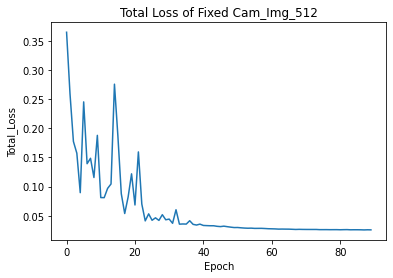

In [16]:
plt.plot(fix_512_avg[10:100])
plt.xlabel("Epoch")
plt.ylabel("Total_Loss")
plt.title("Total Loss of Fixed Cam_Img_512")

Text(0.5, 1.0, 'KLD Loss of Fixed Cam_Img_512')

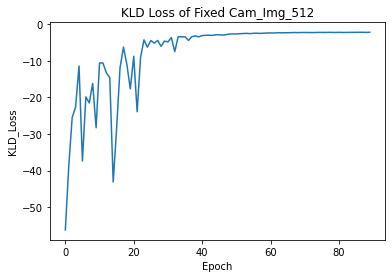

In [46]:
plt.plot(fix_512_kld[10:100])
plt.xlabel("Epoch")
plt.ylabel("KLD_Loss")
plt.title("KLD Loss of Fixed Cam_Img_512")

Text(0.5, 1.0, 'Reconstructed Loss of Fixed Cam_Img_512')

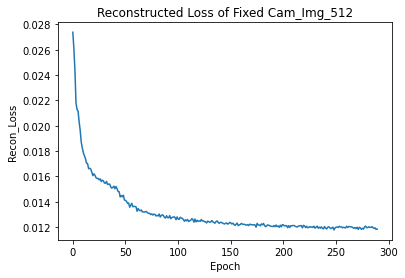

In [49]:
plt.plot(fix_512_recon[10:300])
plt.xlabel("Epoch")
plt.ylabel("Recon_Loss")
plt.title("Reconstructed Loss of Fixed Cam_Img_512")

In [17]:
#Loss for fixed camera target image VAE, latent space dim = 1024
fix_1024_avg = np.load("VAE_Loss_Fixed/RGB_avg_loss_appro_1024.npy")
fix_1024_kld = np.load("VAE_Loss_Fixed/RGB_KLD_loss_appro_1024.npy")
fix_1024_recon = np.load("VAE_Loss_Fixed/RGB_recon_loss_appro_1024.npy")

In [35]:
np.array((50,200))

array([ 50, 200])

Text(0.5, 1.0, 'Total Loss of Fixed Cam_Img_1024')

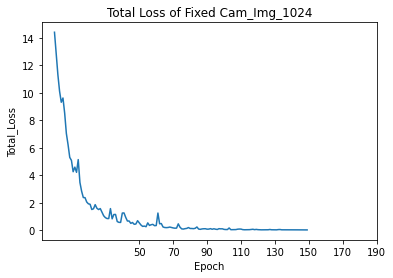

In [37]:
plt.plot(fix_1024_avg[50:200])
plt.xticks(np.arange(50, 200, 20)) 
plt.xlabel("Epoch")
plt.ylabel("Total_Loss")
plt.title("Total Loss of Fixed Cam_Img_1024")

Text(0.5, 1.0, 'KLD Loss of Fixed Cam_Img_1024')

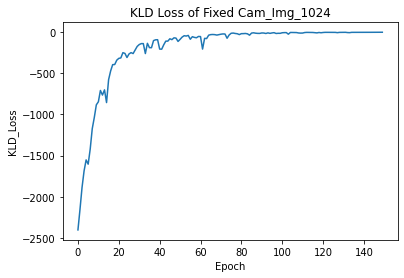

In [50]:
plt.plot(fix_1024_kld[50:200])
plt.xlabel("Epoch")
plt.ylabel("KLD_Loss")
plt.title("KLD Loss of Fixed Cam_Img_1024")

Text(0.5, 1.0, 'Reconstructed Loss of Fixed Cam_Img_1024')

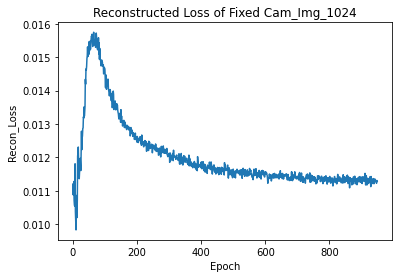

In [60]:
plt.plot(fix_1024_recon[50:])
plt.xlabel("Epoch")
plt.ylabel("Recon_Loss")
plt.title("Reconstructed Loss of Fixed Cam_Img_1024")

### Loss for Changeable Camera Img

In [62]:
#Loss for Changeable camera target image (object as target) VAE, latent space dim = 128
RGB_128_avg = np.load("VAE_Loss_Change_128/RGB_avg_loss_appro.npy")
RGB_128_kld = np.load("VAE_Loss_Change_128/RGB_KLD_loss_appro.npy")
RGB_128_recon = np.load("VAE_Loss_Change_128/RGB_recon_loss_appro.npy")

Text(0.5, 1.0, 'Total Loss of Changeable Cam_Img_128')

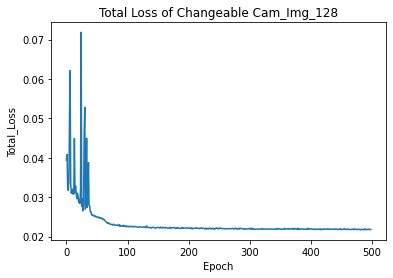

In [71]:
plt.plot(RGB_128_avg[1:])
plt.xlabel("Epoch")
plt.ylabel("Total_Loss")
plt.title("Total Loss of Changeable Cam_Img_128")

Text(0.5, 1.0, 'KLD Loss of Changeable Cam_Img_128')

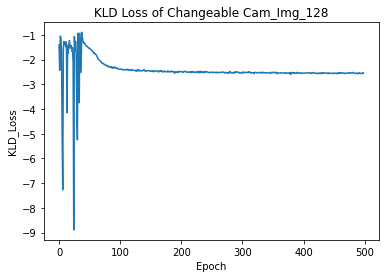

In [70]:
plt.plot(RGB_128_kld[1:])
plt.xlabel("Epoch")
plt.ylabel("KLD_Loss")
plt.title("KLD Loss of Changeable Cam_Img_128")

Text(0.5, 1.0, 'Reconstructed Loss of Changeable Cam_Img_128')

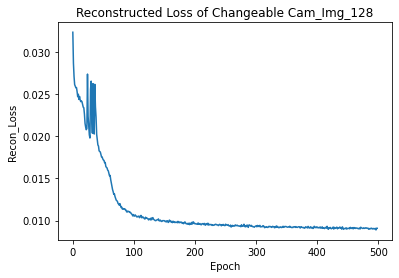

In [69]:
plt.plot(RGB_128_recon[1:])
plt.xlabel("Epoch")
plt.ylabel("Recon_Loss")
plt.title("Reconstructed Loss of Changeable Cam_Img_128")

## VAE For RGB

### Train VAE

In [5]:
#Initial variables
input_channels = 3
EPOCH = 50
BATCH_SIZE = 64
n = 2 #num_worker
LATENT_CODE_NUM = 128 #or larger
log_interval = 10

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#May larger KLD loss for unknown reason, not working well, ignore

# def setup_seed(seed):
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     np.random.seed(seed)
#     random.seed(seed)
#     torch.backends.cudnn.deterministic = True

# # set random seed
# setup_seed(1226)

In [ ]:
#Loading images folder

# transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
#                                 transforms.Resize(64),
#                                 transforms.RandomHorizontalFlip(),
#                                 transforms.ToTensor()
#                                ])

transform = transforms.Compose([transforms.ToTensor()])

dataset_train = dst.ImageFolder('data/generatedImages_v3_64p/appro_train', transform = transform)
# dataset_train = dst.ImageFolder('data/generatedImages_v3_64p/grasp_train', transform = transform)
# dataset_train = dst.ImageFolder('data/generatedImages_v3_64p/retract_train', transform = transform)

In [ ]:
#See the info of images folder
dataset_train

In [ ]:
#Load dataset to dataloader
train_loader = torch.utils.data.DataLoader(dataset = dataset_train, num_workers = n, 
                                           batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
#Initialize vae and optimizer
vae = VAE(input_channels, latent_dim = LATENT_CODE_NUM).to(device)
optimizer = optim.Adam(vae.parameters(), lr = 0.005)

In [ ]:
#See structure of the vae model
vae

In [ ]:
#Train VAE
def trainVAE(startEPOCH, endEPOCH, behavior):
    vae.train()

    avg_loss_list = []
    avg_Reconloss_list = []
    avg_KLDloss_list = []

    for epoch in range(startEPOCH, endEPOCH):
        total_loss = 0
        total_Reconloss = 0
        total_KLDloss = 0

        for i, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.to(device)
            result = vae(data)
            recon_data = result[0]

            loss = vae.loss_function(*result, M_N = 0.005) # M_N is Batch_size/totalDataSize = 64/10052
            loss['loss'].backward()

            total_loss += loss['loss'].data
            total_Reconloss += loss['Reconstruction_Loss'].data
            total_KLDloss += loss['KLD'].data

            optimizer.step()


            if i % log_interval == 0:
                sample = vae.sample(64, device)
                save_image(sample, 'VAE_RGB_' + str(behavior) + '/sample_' + str(epoch) + '.png')
                save_image(recon_data, 'VAE_RGB_' + str(behavior) + '/recon_' + str(epoch) + '.png')

                print('Train Epoch:{} -- [{}/{} ({:.0f}%)] -- Loss:{:.6f}, Recon_Loss:{:.6f}, KLD: {:.6f}'.format(
                    epoch, i*len(data), len(train_loader.dataset), 
                    100.*i/len(train_loader), 
                    loss['loss'].item(), loss['Reconstruction_Loss'].item(), loss['KLD'].item()))

        avg_loss = total_loss / 150 #  totalDataSize/batch_size
        avg_Reconloss = total_Reconloss / 150
        avg_KLDloss = total_KLDloss / 150

        avg_loss_list.append(avg_loss)
        avg_Reconloss_list.append(avg_Reconloss)
        avg_KLDloss_list.append(avg_KLDloss)

        print('====> Epoch: {} Average Loss:{:.6f}, Reconstruction_Loss:{:.6f}, KLD: {:.6f}'.format(
            epoch, avg_loss, avg_Reconloss, avg_KLDloss))

    #Save status
    torch.save(vae.state_dict(), 'VAE_' + str(endEPOCH) + 'EPOCH.pkl')
    np.save("VAE_avgloss_" + str(endEPOCH) + ".npy", np.array(avg_loss_list))
    np.save("VAE_reconloss_" + str(endEPOCH) + ".npy", np.array(avg_Reconloss_list))
    np.save("VAE_KLDloss_" + str(endEPOCH) + ".npy", np.array(avg_KLDloss_list))

In [ ]:
#Make dir for recon and sample images
!mkdir VAE_RGB_appro
# !mkdir VAE_RGB_grasp
# !mkdir VAE_RGB_retract

In [ ]:
# Start Traning
trainVAE(startEPOCH = 0, endEPOCH = 2, behavior = 'appro')

## VAE For Depth

### Load depth images data

In [10]:
#Read depth data, need to update path
DepthPATH = "generatedImagesSavedArray_v3_7Ori64p/depth_array_list/"
#
#Appro
depth_appro1 = np.load(DepthPATH + "depth_array_list_appro_ori1.npy")
depth_appro2 = np.load(DepthPATH + "depth_array_list_appro_ori2.npy")
depth_appro3 = np.load(DepthPATH + "depth_array_list_appro_ori3.npy")
depth_appro4 = np.load(DepthPATH + "depth_array_list_appro_ori4.npy")
depth_appro5 = np.load(DepthPATH + "depth_array_list_appro_ori5.npy")
depth_appro6 = np.load(DepthPATH + "depth_array_list_appro_ori6.npy")
depth_appro7 = np.load(DepthPATH + "depth_array_list_appro_ori7.npy")

# #
# #Grasp
# depth_grasp1 = np.load(DepthPATH + "depth_array_list_grasp_ori1.npy")
# depth_grasp2 = np.load(DepthPATH + "depth_array_list_grasp_ori2.npy")
# depth_grasp3 = np.load(DepthPATH + "depth_array_list_grasp_ori3.npy")
# depth_grasp4 = np.load(DepthPATH + "depth_array_list_grasp_ori4.npy")
# depth_grasp5 = np.load(DepthPATH + "depth_array_list_grasp_ori5.npy")
# depth_grasp6 = np.load(DepthPATH + "depth_array_list_grasp_ori6.npy")
# depth_grasp7 = np.load(DepthPATH + "depth_array_list_grasp_ori7.npy")

# #
# #retract
# depth_retract1 = np.load(DepthPATH + "depth_array_list_retract_ori1.npy")
# depth_retract2 = np.load(DepthPATH + "depth_array_list_retract_ori2.npy")
# depth_retract3 = np.load(DepthPATH + "depth_array_list_retract_ori3.npy")
# depth_retract4 = np.load(DepthPATH + "depth_array_list_retract_ori4.npy")
# depth_retract5 = np.load(DepthPATH + "depth_array_list_retract_ori5.npy")
# depth_retract6 = np.load(DepthPATH + "depth_array_list_retract_ori6.npy")
# depth_retract7 = np.load(DepthPATH + "depth_array_list_retract_ori7.npy")

In [11]:
depth_appro1.shape #see number of images per orientation

(1378, 4096)

In [12]:
depth_appro = []
for i in range(len(depth_appro1)):
    depth_appro.append(torch.tensor(depth_appro1[i].reshape(64,64), dtype = torch.float32))   
    depth_appro.append(torch.tensor(depth_appro2[i].reshape(64,64), dtype = torch.float32))
    depth_appro.append(torch.tensor(depth_appro3[i].reshape(64,64), dtype = torch.float32))
    depth_appro.append(torch.tensor(depth_appro4[i].reshape(64,64), dtype = torch.float32))
    depth_appro.append(torch.tensor(depth_appro5[i].reshape(64,64), dtype = torch.float32))
    depth_appro.append(torch.tensor(depth_appro6[i].reshape(64,64), dtype = torch.float32))
    depth_appro.append(torch.tensor(depth_appro7[i].reshape(64,64), dtype = torch.float32))
    
depth_appro_64 = torch.stack((depth_appro) ,dim = 0)

In [15]:
depth_appro_64.shape

9646

In [16]:
y = torch.IntTensor(depth_appro_64.shape[0]).zero_()
torch_dataset = Data.TensorDataset(depth_appro_64, y)
train_loader = torch.utils.data.DataLoader(dataset = torch_dataset, num_workers = n, 
                                           batch_size = BATCH_SIZE, shuffle = True)

### Train VAE

In [21]:
#Initial variables
input_channels = 1
EPOCH = 50
BATCH_SIZE = 64
n = 2 #num_worker
LATENT_CODE_NUM = 128 #or larger
log_interval = 10

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
vae = VAE(input_channels, latent_dim = LATENT_CODE_NUM).to(device)
optimizer = optim.Adam(vae.parameters(), lr = 0.005)

In [23]:
vae

VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Lin

In [ ]:
def trainDepthVAE(startEPOCH, endEPOCH):
    vae.train()

    avg_loss_list = []
    avg_Reconloss_list = []
    avg_KLDloss_list = []

    for epoch in range(startEPOCH, endEPOCH):
        total_loss = 0
        total_Reconloss = 0
        total_KLDloss = 0

        for i, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.to(device)
            result = vae(data)
            recon_data = result[0]

            loss = vae.loss_function(*result, M_N = 0.005) # M_N is Batch_size/totalDataSize = 64/10052
            loss['loss'].backward()

            total_loss += loss['loss'].data
            total_Reconloss += loss['Reconstruction_Loss'].data
            total_KLDloss += loss['KLD'].data

            optimizer.step()


            if i % log_interval == 0:
                sample = vae.sample(64, device)
                save_image(sample, 'VAE_depth_appro/sample_' + str(epoch) + '.png')
                save_image(recon_data, 'VAE_depth_appro/recon_' + str(epoch) + '.png')

                print('Train Epoch:{} -- [{}/{} ({:.0f}%)] -- Loss:{:.6f}, Recon_Loss:{:.6f}, KLD: {:.6f}'.format(
                    epoch, i*len(data), len(train_loader.dataset), 
                    100.*i/len(train_loader), 
                    loss['loss'].item(), loss['Reconstruction_Loss'].item(), loss['KLD'].item()))

        avg_loss = total_loss / 150 #  totalDataSize/batch_size
        avg_Reconloss = total_Reconloss / 150
        avg_KLDloss = total_KLDloss / 150

        avg_loss_list.append(avg_loss)
        avg_Reconloss_list.append(avg_Reconloss)
        avg_KLDloss_list.append(avg_KLDloss)

        print('====> Epoch: {} Average Loss:{:.6f}, Reconstruction_Loss:{:.6f}, KLD: {:.6f}'.format(
            epoch, avg_loss, avg_Reconloss, avg_KLDloss))

    #Save status
    torch.save(vae.state_dict(), 'VAE_' + str(endEPOCH) + 'EPOCH.pkl')
    np.save("VAE_avgloss_" + str(endEPOCH) + ".npy", np.array(avg_loss_list))
    np.save("VAE_reconloss_" + str(endEPOCH) + ".npy", np.array(avg_Reconloss_list))
    np.save("VAE_KLDloss_" + str(endEPOCH) + ".npy", np.array(avg_KLDloss_list))

#     #Move saved status to google drive
#     shutil.move("VAE_"+ str(endEPOCH) + "EPOCH.pkl", "/content/drive/My Drive/MSc Project/VAE_result_depth_appro")
#     shutil.move("VAE_KLDloss_"+ str(endEPOCH) + ".npy", "/content/drive/My Drive/MSc Project/VAE_result_depth_appro")
#     shutil.move("VAE_avgloss_"+ str(endEPOCH) + ".npy", "/content/drive/My Drive/MSc Project/VAE_result_depth_appro")
#     shutil.move("VAE_reconloss_"+ str(endEPOCH) + ".npy", "/content/drive/My Drive/MSc Project/VAE_result_depth_appro")



In [ ]:
!mkdir VAE_depth_appro
# !mkdir VAE_depth_grasp
# !mkdir VAE_depth_retract

In [ ]:
# Start Traning
trainDepthVAE(startEPOCH = 0, endEPOCH = 100)

### Loss Result

In [73]:
#Loss for Changeable camera target image (object as target) VAE, latent space dim = 128
depth_128_avg = np.load("VAE_Loss_Change_128/Depth_avg_loss_appro.npy")
depth_128_kld = np.load("VAE_Loss_Change_128/Depth_KLD_loss_appro.npy")
depth_128_recon = np.load("VAE_Loss_Change_128/Depth_recon_loss_appro.npy")

In [75]:
len(depth_128_avg)

800

Text(0.5, 1.0, 'Total Loss of Depth_Img Version')

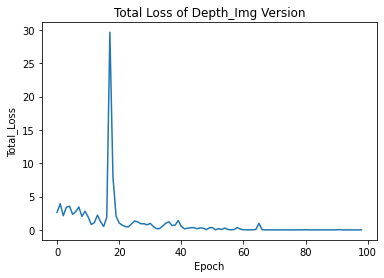

In [77]:
plt.plot(depth_128_avg[1:100])
plt.xlabel("Epoch")
plt.ylabel("Total_Loss")
plt.title("Total Loss of Depth_Img Version")

Text(0.5, 1.0, 'KLD Loss of Depth_Img Version')

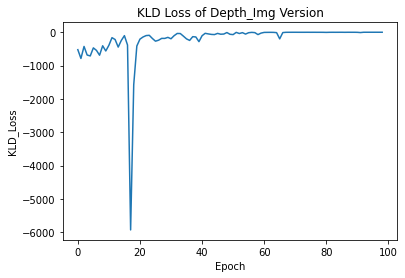

In [79]:
plt.plot(depth_128_kld[1:100])
plt.xlabel("Epoch")
plt.ylabel("KLD_Loss")
plt.title("KLD Loss of Depth_Img Version")

Text(0.5, 1.0, 'Reconstructed Loss of Depth_Img Version')

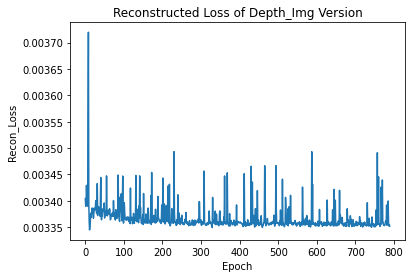

In [84]:
plt.plot(depth_128_recon[10:])
plt.xlabel("Epoch")
plt.ylabel("Recon_Loss")
plt.title("Reconstructed Loss of Depth_Img Version")

## VAE For RGB-Depth

### Load and prepare training data

In [24]:
def loadRGBD(behavior):
    rgbPATH = "generatedImagesSavedArray_v3_7Ori64p/rgb_array_list/"
    depthPATH = "generatedImagesSavedArray_v3_7Ori64p/depth_array_list/"
    
    rgb_appro1 = np.load(rgbPATH + "rgb_array_list_" + str(behavior) + "_ori1.npy")
    rgb_appro2 = np.load(rgbPATH + "rgb_array_list_" + str(behavior) + "_ori2.npy")
    rgb_appro3 = np.load(rgbPATH + "rgb_array_list_" + str(behavior) + "_ori3.npy")
    rgb_appro4 = np.load(rgbPATH + "rgb_array_list_" + str(behavior) + "_ori4.npy")
    rgb_appro5 = np.load(rgbPATH + "rgb_array_list_" + str(behavior) + "_ori5.npy")
    rgb_appro6 = np.load(rgbPATH + "rgb_array_list_" + str(behavior) + "_ori6.npy")
    rgb_appro7 = np.load(rgbPATH + "rgb_array_list_" + str(behavior) + "_ori7.npy")

    depth_appro1 = np.load(depthPATH + "depth_array_list_" + str(behavior) + "_ori1.npy")
    depth_appro2 = np.load(depthPATH + "depth_array_list_" + str(behavior) + "_ori2.npy")
    depth_appro3 = np.load(depthPATH + "depth_array_list_" + str(behavior) + "_ori3.npy")
    depth_appro4 = np.load(depthPATH + "depth_array_list_" + str(behavior) + "_ori4.npy")
    depth_appro5 = np.load(depthPATH + "depth_array_list_" + str(behavior) + "_ori5.npy")
    depth_appro6 = np.load(depthPATH + "depth_array_list_" + str(behavior) + "_ori6.npy")
    depth_appro7 = np.load(depthPATH + "depth_array_list_" + str(behavior) + "_ori7.npy")
    
    rgb_appro = []
    for i in range(len(rgb_appro1)):
        rgb_appro.append(TF.to_tensor(rgb_appro1[i]))   
        rgb_appro.append(TF.to_tensor(rgb_appro2[i]))
        rgb_appro.append(TF.to_tensor(rgb_appro3[i]))
        rgb_appro.append(TF.to_tensor(rgb_appro4[i]))
        rgb_appro.append(TF.to_tensor(rgb_appro5[i]))
        rgb_appro.append(TF.to_tensor(rgb_appro6[i]))
        rgb_appro.append(TF.to_tensor(rgb_appro7[i]))
    
    depth_appro = []
    for i in range(len(depth_appro1)):
        depth_appro.append(torch.tensor(depth_appro1[i].reshape(64,64), dtype = torch.float32))   
        depth_appro.append(torch.tensor(depth_appro2[i].reshape(64,64), dtype = torch.float32))
        depth_appro.append(torch.tensor(depth_appro3[i].reshape(64,64), dtype = torch.float32))
        depth_appro.append(torch.tensor(depth_appro4[i].reshape(64,64), dtype = torch.float32))
        depth_appro.append(torch.tensor(depth_appro5[i].reshape(64,64), dtype = torch.float32))
        depth_appro.append(torch.tensor(depth_appro6[i].reshape(64,64), dtype = torch.float32))
        depth_appro.append(torch.tensor(depth_appro7[i].reshape(64,64), dtype = torch.float32))
        
    rgb_d = []
    for i in range(len(rgb_appro)):
        rgb_d.append(torch.stack((rgb_appro[i][0], rgb_appro[i][1], 
                                  rgb_appro[i][2], depth_appro[i]) ,dim = 0))

    
    
    return torch.stack(rgb_d)

In [25]:
rgbd_appro = loadRGBD('appro')
# rgbd_grasp = loadRGBD('grasp')
# rgbd_retract = loadRGBD('retract')

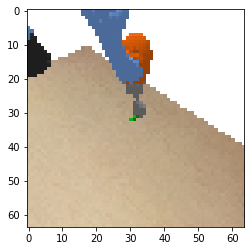

In [26]:
#RGB images

plt.imshow(rgbd_appro[113][:3].permute(1,2,0))
# plt.imshow(rgbd_grasp[113][:3].permute(1,2,0))
# # plt.imshow(rgbd_retract[113][:3].permute(1,2,0))

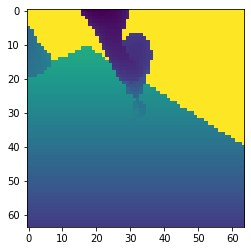

In [29]:
#Depth Images

plt.imshow(rgbd_appro[113][3])
# plt.imshow(rgbd_grasp[113][3])
# plt.imshow(rgbd_retract[113][3])

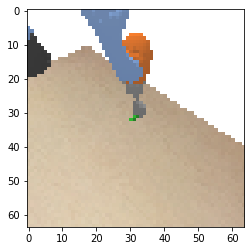

In [28]:
#RGBD Images

# plt.imshow(rgbd_appro[113].permute(1,2,0))
plt.imshow(rgbd_grasp[113].permute(1,2,0))
# plt.imshow(rgbd_retract[113].permute(1,2,0))

In [30]:
y = torch.IntTensor(len(rgbd_appro)).zero_()
torch_dataset = Data.TensorDataset(rgbd_appro, y)

### Train VAE

In [31]:
#Initial variables
input_channels = 4
EPOCH = 50
BATCH_SIZE = 64
n = 2 #num_worker
LATENT_CODE_NUM = 128 #or larger
log_interval = 10

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [32]:
train_loader = torch.utils.data.DataLoader(dataset = torch_dataset, num_workers = n, 
                                           batch_size = BATCH_SIZE, shuffle = True)

In [33]:
vae = VAE(input_channels, latent_dim = LATENT_CODE_NUM).to(device)
optimizer = optim.Adam(vae.parameters(), lr = 0.005)

In [34]:
vae

VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Lin

In [ ]:
def trainRGBDVAE(startEPOCH, endEPOCH, behavior):
    vae.train()

    avg_loss_list = []
    avg_Reconloss_list = []
    avg_KLDloss_list = []

    for epoch in range(startEPOCH, endEPOCH):
        total_loss = 0
        total_Reconloss = 0
        total_KLDloss = 0

        for i, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.to(device)
            result = vae(data)
            recon_data = result[0]

            loss = vae.loss_function(*result, M_N = 0.005) # M_N is Batch_size/totalDataSize = 64/10052
            loss['loss'].backward()

            total_loss += loss['loss'].data
            total_Reconloss += loss['Reconstruction_Loss'].data
            total_KLDloss += loss['KLD'].data

            optimizer.step()


            if i % log_interval == 0:
                sample = vae.sample(64, device)
                save_image(sample, 'VAE_RGBD_' + str(behavior) + '/sample_' + str(epoch) + '.png')
                save_image(recon_data, 'VAE_RGBD_' + str(behavior) + '/recon_' + str(epoch) + '.png')

                print('Train Epoch:{} -- [{}/{} ({:.0f}%)] -- Loss:{:.6f}, Recon_Loss:{:.6f}, KLD: {:.6f}'.format(
                    epoch, i*len(data), len(train_loader.dataset), 
                    100.*i/len(train_loader), 
                    loss['loss'].item(), loss['Reconstruction_Loss'].item(), loss['KLD'].item()))

        avg_loss = total_loss / 150 #  totalDataSize/batch_size
        avg_Reconloss = total_Reconloss / 150
        avg_KLDloss = total_KLDloss / 150

        avg_loss_list.append(avg_loss)
        avg_Reconloss_list.append(avg_Reconloss)
        avg_KLDloss_list.append(avg_KLDloss)

        print('====> Epoch: {} Average Loss:{:.6f}, Reconstruction_Loss:{:.6f}, KLD: {:.6f}'.format(
            epoch, avg_loss, avg_Reconloss, avg_KLDloss))

    #Save status
    torch.save(vae.state_dict(), 'VAE_' + str(endEPOCH) + 'EPOCH.pkl')
    np.save("VAE_avgloss_" + str(endEPOCH) + ".npy", np.array(avg_loss_list))
    np.save("VAE_reconloss_" + str(endEPOCH) + ".npy", np.array(avg_Reconloss_list))
    np.save("VAE_KLDloss_" + str(endEPOCH) + ".npy", np.array(avg_KLDloss_list))

In [ ]:
!mkdir VAE_RGBD_appro

In [ ]:
# Start Traning
trainDepthVAE(startEPOCH = 0, endEPOCH = 2, behavior = 'appro')

### Loss result

In [85]:
#Loss for Changeable camera target image (object as target) VAE, latent space dim = 128
rgbd_128_avg = np.load("VAE_Loss_Change_128/RGBD_avg_loss_appro.npy")
rgbd_128_kld = np.load("VAE_Loss_Change_128/RGBD_KLD_loss_appro.npy")
rgbd_128_recon = np.load("VAE_Loss_Change_128/RGBD_recon_loss_appro.npy")


In [86]:
len(rgbd_128_avg)

500

Text(0.5, 1.0, 'Total Loss of RGBD_Img Version')

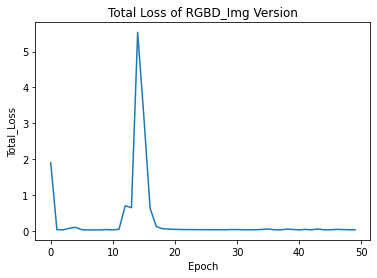

In [91]:
plt.plot(rgbd_128_avg[:50])
plt.xlabel("Epoch")
plt.ylabel("Total_Loss")
plt.title("Total Loss of RGBD_Img Version")

Text(0.5, 1.0, 'KLD Loss of RGBD_Img Version')

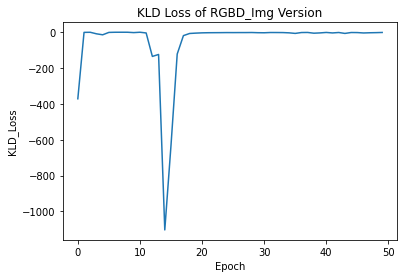

In [95]:
plt.plot(rgbd_128_kld[:50])
plt.xlabel("Epoch")
plt.ylabel("KLD_Loss")
plt.title("KLD Loss of RGBD_Img Version")

Text(0.5, 1.0, 'Reconstructed Loss of RGBD_Img Version')

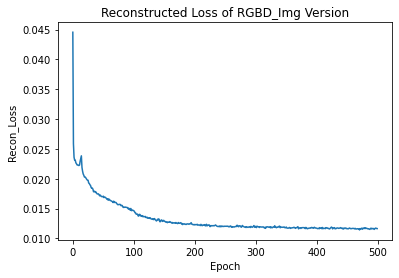

In [94]:
plt.plot(rgbd_128_recon)
plt.xlabel("Epoch")
plt.ylabel("Recon_Loss")
plt.title("Reconstructed Loss of RGBD_Img Version")

# Regression

In [6]:
# Regression model selected

class regressionNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(regressionNet, self).__init__()
        
        self.layer1 = nn.Linear(in_dim, out_dim)
 
    def forward(self, x):
        x = self.layer1(x)
        return x

In [33]:
# class regressionNet2(nn.Module):
#     def __init__(self, in_dim, out_dim):
#         super(regressionNet2, self).__init__()
        
#         self.layer1 = nn.Linear(in_dim, 64)
#         self.layer2 = nn.Linear(64, 16)
#         self.layer3 = nn.Linear(16, out_dim)
 
#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         return x

## Prepare training data

In [6]:
#Initialize vae to load trained vae
#Initial variables
input_channels = 3
LATENT_CODE_NUM = 128 #or larger

In [7]:
#Before run this, please be sure to run VAE class in chapter 3.
vae_appro = VAE(input_channels, latent_dim = LATENT_CODE_NUM).to(device)

In [8]:
vae_appro

VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Lin

In [9]:
#Load trained RGB-version VAE
vae_appro.load_state_dict(torch.load(
    "VAE_result_RGB_v3_BasedOn7OriImg/VAE_result_appro/VAE_500EPOCH.pkl", 
    map_location=torch.device('cpu')))

<All keys matched successfully>

### Encode Initial State Images

In [10]:
imgFolder_PATH = "generatedImagesSavedArray_v3_7Ori64p_addInitial/rgb/"

rgb_array_list_initial_ori1_load = np.load(imgFolder_PATH + "rgb_array_list_initial_ori1.npy")
rgb_array_list_initial_ori2_load = np.load(imgFolder_PATH + "rgb_array_list_initial_ori2.npy")
rgb_array_list_initial_ori3_load = np.load(imgFolder_PATH + "rgb_array_list_initial_ori3.npy")
rgb_array_list_initial_ori4_load = np.load(imgFolder_PATH + "rgb_array_list_initial_ori4.npy")
rgb_array_list_initial_ori5_load = np.load(imgFolder_PATH + "rgb_array_list_initial_ori5.npy")
rgb_array_list_initial_ori6_load = np.load(imgFolder_PATH + "rgb_array_list_initial_ori6.npy")
rgb_array_list_initial_ori7_load = np.load(imgFolder_PATH + "rgb_array_list_initial_ori7.npy")

In [11]:
rgb_array_list_initial_ori1_load.shape

(1393, 64, 64, 3)

In [12]:
rgb_initial = []
for i in range(len(rgb_array_list_initial_ori1_load)):
    rgb_initial.append(TF.to_tensor(rgb_array_list_initial_ori1_load[i]))   
    rgb_initial.append(TF.to_tensor(rgb_array_list_initial_ori2_load[i]))
    rgb_initial.append(TF.to_tensor(rgb_array_list_initial_ori3_load[i]))
    rgb_initial.append(TF.to_tensor(rgb_array_list_initial_ori4_load[i]))
    rgb_initial.append(TF.to_tensor(rgb_array_list_initial_ori5_load[i]))
    rgb_initial.append(TF.to_tensor(rgb_array_list_initial_ori6_load[i]))
    rgb_initial.append(TF.to_tensor(rgb_array_list_initial_ori7_load[i]))
    
rgb_initial_tensor = torch.stack((rgb_initial) ,dim = 0)

In [13]:
rgb_initial_tensor.shape

torch.Size([9751, 3, 64, 64])

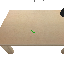

In [14]:
TF.to_pil_image(rgb_initial_tensor[200])

In [15]:
latent_appro_encode = vae_appro.encode(rgb_initial_tensor)

In [16]:
latent_appro_encode[0].shape

torch.Size([9751, 128])

In [17]:
#stack mu and log_var
latent_appro = torch.cat((latent_appro_encode[0], latent_appro_encode[1]), dim = 1)
latent_appro = latent_appro.data

In [18]:
latent_appro.shape

torch.Size([9751, 256])

In [19]:
latent_appro

tensor([[ 0.0744,  0.0249, -0.1142,  ...,  0.0219,  0.0558,  0.0006],
        [ 0.0910, -0.0308, -0.0313,  ...,  0.0433,  0.0012,  0.0028],
        [ 0.0562,  0.0662, -0.0315,  ...,  0.0313,  0.0358, -0.0229],
        ...,
        [ 0.0164,  0.0384, -0.0304,  ...,  0.1019,  0.0678, -0.0156],
        [-0.0130,  0.0204,  0.0215,  ...,  0.0566,  0.0944, -0.0346],
        [-0.0394,  0.0119, -0.0183,  ...,  0.0337,  0.0587,  0.0076]])

In [20]:
#test decode from latent space
test_result = vae_appro.decode(vae_appro.reparameterize(latent_appro[200][:128], latent_appro[200][128:256]))

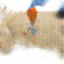

In [21]:
#Test OK
TF.to_pil_image(test_result[0])

### Load states

In [82]:
#Load states
Folder_PATH = "generatedImagesSavedArray_v3_7Ori64p_addInitial/"

rgb_objectStates_list_load = np.load(Folder_PATH + "obj/objectStates_list_appro.npy", 
                                     allow_pickle=True)

rgb_endEffeStates_list_load = np.load(Folder_PATH + "endEff/endEffeStates_list_appro.npy", 
                                      allow_pickle=True)


In [23]:
# x, y, z
# np.array(rgb_objectStates_list_load[0][0])

In [24]:
#Orientation
# np.array(rgb_objectStates_list_load[0][1])

In [25]:
#Stact the array
# np.append(np.array(rgb_objectStates_list_load[0][0]), np.array(rgb_objectStates_list_load[0][1]))

In [26]:
#x,y,z of endEffector
# np.array(rgb_endEffeStates_list_load[0][0])

In [27]:
# objEndStates_appro = []
# for i in range(len(rgb_objectStates_list_load)):
#     obj = np.array(rgb_objectStates_list_load[i][0])
#     end = np.array(rgb_endEffeStates_list_load[i][0])
    
#     for j in range(7): 
#         objEndStates_appro.append(torch.tensor(np.append(obj, end), dtype = torch.float32))
        
# rgb_states_appro = torch.stack((objEndStates_appro),dim = 0)

In [83]:
#Store the position and orientation of end effector
endStates_appro = []
for i in range(len(rgb_objectStates_list_load)):
    pos = np.array(rgb_endEffeStates_list_load[i][0])
    ori = np.array(rgb_objectStates_list_load[i][1])
    
    for j in range(7): 
        endStates_appro.append(torch.tensor(np.append(pos, ori), dtype = torch.float32))
        
rgb_states_appro = torch.stack((endStates_appro),dim = 0)

In [84]:
#posisition (3-dim) and orientation (4-dim) of endeffector
rgb_states_appro.shape

torch.Size([9751, 7])

In [85]:
rgb_states_appro

tensor([[6.4409e-01, 1.8515e-01, 6.6092e-02,  ..., 4.3316e-09, 9.2409e-01,
         3.8218e-01],
        [6.4409e-01, 1.8515e-01, 6.6092e-02,  ..., 4.3316e-09, 9.2409e-01,
         3.8218e-01],
        [6.4409e-01, 1.8515e-01, 6.6092e-02,  ..., 4.3316e-09, 9.2409e-01,
         3.8218e-01],
        ...,
        [5.8677e-01, 7.9135e-04, 6.6092e-02,  ..., 1.9455e-12, 7.2918e-01,
         6.8432e-01],
        [5.8677e-01, 7.9135e-04, 6.6092e-02,  ..., 1.9455e-12, 7.2918e-01,
         6.8432e-01],
        [5.8677e-01, 7.9135e-04, 6.6092e-02,  ..., 1.9455e-12, 7.2918e-01,
         6.8432e-01]])

## Train regression

In [9]:
#This section is used to train all regressions

In [7]:
#Initialize the regression
#Input of regression is mean and variance of VAE. VAE dimension is 128, stacked mean and variance dimension is 256.

regression = regressionNet(in_dim = 256, out_dim = 7).to(device)
# regression = regressionNet2(in_dim = 256, out_dim = 7).to(device)
optimizer = optim.Adam(regression.parameters(), lr = 0.005)
criterion = nn.MSELoss()

In [8]:
regression

regressionNet(
  (layer1): Linear(in_features=256, out_features=7, bias=True)
)

In [36]:
torch_dataset = Data.TensorDataset(latent_appro, rgb_states_appro)
train_loader = torch.utils.data.DataLoader(dataset = torch_dataset, num_workers = n, 
                                           batch_size = BATCH_SIZE, shuffle = True)

In [37]:
def trainRegression(startEPOCH, endEPOCH):
    regression.train()

    totalloss_list = []

    for epoch in range(startEPOCH, endEPOCH):
        total_loss = 0

        for i, (data, state) in enumerate(train_loader):
            optimizer.zero_grad()
            data = data.to(device)
            state = state.to(device)
            
            result = regression(data)

            loss = criterion(result, state)
            loss.backward() #MSE loss in the batch

            total_loss += loss.data

            optimizer.step()


            if i % 50 == 0:

                print('Train Epoch:{} -- [{}/{} ({:.0f}%)] -- Loss:{:.6f}'.format(
                    epoch, i*len(data), len(train_loader.dataset), 100.*i/len(train_loader), loss.item()))

        totalloss_list.append(total_loss)

        print('====> Epoch: {} Average Loss:{:.6f}'.format(epoch, total_loss))
        
    np.save("Regression_loss_" + str(endEPOCH) + ".npy", np.array(totalloss_list))
    torch.save(regression.state_dict(), 'Regression_appro_' + str(endEPOCH) + '.pkl')
    
    return np.array(totalloss_list)

In [38]:
totalloss_list = trainRegression(0, 500)

Train Epoch:0 -- [0/9751 (0%)] -- Loss:0.242153
Train Epoch:0 -- [3200/9751 (33%)] -- Loss:0.013727
Train Epoch:0 -- [6400/9751 (65%)] -- Loss:0.007527
Train Epoch:0 -- [9600/9751 (98%)] -- Loss:0.016051
====> Epoch: 0 Average Loss:2.782912
Train Epoch:1 -- [0/9751 (0%)] -- Loss:0.005845
Train Epoch:1 -- [3200/9751 (33%)] -- Loss:0.018007
Train Epoch:1 -- [6400/9751 (65%)] -- Loss:0.008365
Train Epoch:1 -- [9600/9751 (98%)] -- Loss:0.008210
====> Epoch: 1 Average Loss:1.546664
Train Epoch:2 -- [0/9751 (0%)] -- Loss:0.009355
Train Epoch:2 -- [3200/9751 (33%)] -- Loss:0.006049
Train Epoch:2 -- [6400/9751 (65%)] -- Loss:0.008968
Train Epoch:2 -- [9600/9751 (98%)] -- Loss:0.010073
====> Epoch: 2 Average Loss:1.482685
Train Epoch:3 -- [0/9751 (0%)] -- Loss:0.010916
Train Epoch:3 -- [3200/9751 (33%)] -- Loss:0.013465
Train Epoch:3 -- [6400/9751 (65%)] -- Loss:0.013997
Train Epoch:3 -- [9600/9751 (98%)] -- Loss:0.010681
====> Epoch: 3 Average Loss:1.442066
Train Epoch:4 -- [0/9751 (0%)] -- Lo

Train Epoch:33 -- [9600/9751 (98%)] -- Loss:0.005127
====> Epoch: 33 Average Loss:1.302634
Train Epoch:34 -- [0/9751 (0%)] -- Loss:0.009396
Train Epoch:34 -- [3200/9751 (33%)] -- Loss:0.006012
Train Epoch:34 -- [6400/9751 (65%)] -- Loss:0.006169
Train Epoch:34 -- [9600/9751 (98%)] -- Loss:0.007894
====> Epoch: 34 Average Loss:1.312663
Train Epoch:35 -- [0/9751 (0%)] -- Loss:0.008419
Train Epoch:35 -- [3200/9751 (33%)] -- Loss:0.006926
Train Epoch:35 -- [6400/9751 (65%)] -- Loss:0.006420
Train Epoch:35 -- [9600/9751 (98%)] -- Loss:0.005318
====> Epoch: 35 Average Loss:1.310607
Train Epoch:36 -- [0/9751 (0%)] -- Loss:0.007490
Train Epoch:36 -- [3200/9751 (33%)] -- Loss:0.008814
Train Epoch:36 -- [6400/9751 (65%)] -- Loss:0.007471
Train Epoch:36 -- [9600/9751 (98%)] -- Loss:0.009514
====> Epoch: 36 Average Loss:1.305881
Train Epoch:37 -- [0/9751 (0%)] -- Loss:0.011040
Train Epoch:37 -- [3200/9751 (33%)] -- Loss:0.008711
Train Epoch:37 -- [6400/9751 (65%)] -- Loss:0.008470
Train Epoch:37 -

Train Epoch:67 -- [0/9751 (0%)] -- Loss:0.004199
Train Epoch:67 -- [3200/9751 (33%)] -- Loss:0.010744
Train Epoch:67 -- [6400/9751 (65%)] -- Loss:0.009704
Train Epoch:67 -- [9600/9751 (98%)] -- Loss:0.009968
====> Epoch: 67 Average Loss:1.263024
Train Epoch:68 -- [0/9751 (0%)] -- Loss:0.008111
Train Epoch:68 -- [3200/9751 (33%)] -- Loss:0.005582
Train Epoch:68 -- [6400/9751 (65%)] -- Loss:0.007074
Train Epoch:68 -- [9600/9751 (98%)] -- Loss:0.005123
====> Epoch: 68 Average Loss:1.262280
Train Epoch:69 -- [0/9751 (0%)] -- Loss:0.004586
Train Epoch:69 -- [3200/9751 (33%)] -- Loss:0.006368
Train Epoch:69 -- [6400/9751 (65%)] -- Loss:0.005837
Train Epoch:69 -- [9600/9751 (98%)] -- Loss:0.008962
====> Epoch: 69 Average Loss:1.261839
Train Epoch:70 -- [0/9751 (0%)] -- Loss:0.008867
Train Epoch:70 -- [3200/9751 (33%)] -- Loss:0.006003
Train Epoch:70 -- [6400/9751 (65%)] -- Loss:0.007033
Train Epoch:70 -- [9600/9751 (98%)] -- Loss:0.007579
====> Epoch: 70 Average Loss:1.270209
Train Epoch:71 -

Train Epoch:100 -- [9600/9751 (98%)] -- Loss:0.009180
====> Epoch: 100 Average Loss:1.250386
Train Epoch:101 -- [0/9751 (0%)] -- Loss:0.012666
Train Epoch:101 -- [3200/9751 (33%)] -- Loss:0.007340
Train Epoch:101 -- [6400/9751 (65%)] -- Loss:0.013160
Train Epoch:101 -- [9600/9751 (98%)] -- Loss:0.005950
====> Epoch: 101 Average Loss:1.242554
Train Epoch:102 -- [0/9751 (0%)] -- Loss:0.007756
Train Epoch:102 -- [3200/9751 (33%)] -- Loss:0.009448
Train Epoch:102 -- [6400/9751 (65%)] -- Loss:0.009105
Train Epoch:102 -- [9600/9751 (98%)] -- Loss:0.006266
====> Epoch: 102 Average Loss:1.258594
Train Epoch:103 -- [0/9751 (0%)] -- Loss:0.012054
Train Epoch:103 -- [3200/9751 (33%)] -- Loss:0.008035
Train Epoch:103 -- [6400/9751 (65%)] -- Loss:0.004470
Train Epoch:103 -- [9600/9751 (98%)] -- Loss:0.005670
====> Epoch: 103 Average Loss:1.249098
Train Epoch:104 -- [0/9751 (0%)] -- Loss:0.004899
Train Epoch:104 -- [3200/9751 (33%)] -- Loss:0.006076
Train Epoch:104 -- [6400/9751 (65%)] -- Loss:0.007

Train Epoch:133 -- [9600/9751 (98%)] -- Loss:0.007846
====> Epoch: 133 Average Loss:1.242816
Train Epoch:134 -- [0/9751 (0%)] -- Loss:0.014723
Train Epoch:134 -- [3200/9751 (33%)] -- Loss:0.006403
Train Epoch:134 -- [6400/9751 (65%)] -- Loss:0.009479
Train Epoch:134 -- [9600/9751 (98%)] -- Loss:0.006944
====> Epoch: 134 Average Loss:1.244673
Train Epoch:135 -- [0/9751 (0%)] -- Loss:0.007878
Train Epoch:135 -- [3200/9751 (33%)] -- Loss:0.009213
Train Epoch:135 -- [6400/9751 (65%)] -- Loss:0.004511
Train Epoch:135 -- [9600/9751 (98%)] -- Loss:0.010948
====> Epoch: 135 Average Loss:1.241725
Train Epoch:136 -- [0/9751 (0%)] -- Loss:0.009558
Train Epoch:136 -- [3200/9751 (33%)] -- Loss:0.007547
Train Epoch:136 -- [6400/9751 (65%)] -- Loss:0.005012
Train Epoch:136 -- [9600/9751 (98%)] -- Loss:0.010055
====> Epoch: 136 Average Loss:1.238071
Train Epoch:137 -- [0/9751 (0%)] -- Loss:0.009321
Train Epoch:137 -- [3200/9751 (33%)] -- Loss:0.005065
Train Epoch:137 -- [6400/9751 (65%)] -- Loss:0.010

Train Epoch:166 -- [9600/9751 (98%)] -- Loss:0.005138
====> Epoch: 166 Average Loss:1.230264
Train Epoch:167 -- [0/9751 (0%)] -- Loss:0.007282
Train Epoch:167 -- [3200/9751 (33%)] -- Loss:0.007490
Train Epoch:167 -- [6400/9751 (65%)] -- Loss:0.006728
Train Epoch:167 -- [9600/9751 (98%)] -- Loss:0.005047
====> Epoch: 167 Average Loss:1.226220
Train Epoch:168 -- [0/9751 (0%)] -- Loss:0.010994
Train Epoch:168 -- [3200/9751 (33%)] -- Loss:0.011108
Train Epoch:168 -- [6400/9751 (65%)] -- Loss:0.011641
Train Epoch:168 -- [9600/9751 (98%)] -- Loss:0.005374
====> Epoch: 168 Average Loss:1.233522
Train Epoch:169 -- [0/9751 (0%)] -- Loss:0.004537
Train Epoch:169 -- [3200/9751 (33%)] -- Loss:0.008043
Train Epoch:169 -- [6400/9751 (65%)] -- Loss:0.007382
Train Epoch:169 -- [9600/9751 (98%)] -- Loss:0.015386
====> Epoch: 169 Average Loss:1.228852
Train Epoch:170 -- [0/9751 (0%)] -- Loss:0.007470
Train Epoch:170 -- [3200/9751 (33%)] -- Loss:0.008533
Train Epoch:170 -- [6400/9751 (65%)] -- Loss:0.008

Train Epoch:199 -- [9600/9751 (98%)] -- Loss:0.006974
====> Epoch: 199 Average Loss:1.224422
Train Epoch:200 -- [0/9751 (0%)] -- Loss:0.006974
Train Epoch:200 -- [3200/9751 (33%)] -- Loss:0.004842
Train Epoch:200 -- [6400/9751 (65%)] -- Loss:0.008345
Train Epoch:200 -- [9600/9751 (98%)] -- Loss:0.007565
====> Epoch: 200 Average Loss:1.222605
Train Epoch:201 -- [0/9751 (0%)] -- Loss:0.006757
Train Epoch:201 -- [3200/9751 (33%)] -- Loss:0.009241
Train Epoch:201 -- [6400/9751 (65%)] -- Loss:0.006223
Train Epoch:201 -- [9600/9751 (98%)] -- Loss:0.008012
====> Epoch: 201 Average Loss:1.234441
Train Epoch:202 -- [0/9751 (0%)] -- Loss:0.010870
Train Epoch:202 -- [3200/9751 (33%)] -- Loss:0.008438
Train Epoch:202 -- [6400/9751 (65%)] -- Loss:0.006879
Train Epoch:202 -- [9600/9751 (98%)] -- Loss:0.007961
====> Epoch: 202 Average Loss:1.232966
Train Epoch:203 -- [0/9751 (0%)] -- Loss:0.008233
Train Epoch:203 -- [3200/9751 (33%)] -- Loss:0.005658
Train Epoch:203 -- [6400/9751 (65%)] -- Loss:0.005

Train Epoch:232 -- [9600/9751 (98%)] -- Loss:0.005373
====> Epoch: 232 Average Loss:1.222011
Train Epoch:233 -- [0/9751 (0%)] -- Loss:0.007644
Train Epoch:233 -- [3200/9751 (33%)] -- Loss:0.005811
Train Epoch:233 -- [6400/9751 (65%)] -- Loss:0.008272
Train Epoch:233 -- [9600/9751 (98%)] -- Loss:0.004458
====> Epoch: 233 Average Loss:1.219412
Train Epoch:234 -- [0/9751 (0%)] -- Loss:0.008446
Train Epoch:234 -- [3200/9751 (33%)] -- Loss:0.006398
Train Epoch:234 -- [6400/9751 (65%)] -- Loss:0.011709
Train Epoch:234 -- [9600/9751 (98%)] -- Loss:0.008007
====> Epoch: 234 Average Loss:1.225060
Train Epoch:235 -- [0/9751 (0%)] -- Loss:0.005732
Train Epoch:235 -- [3200/9751 (33%)] -- Loss:0.011078
Train Epoch:235 -- [6400/9751 (65%)] -- Loss:0.008427
Train Epoch:235 -- [9600/9751 (98%)] -- Loss:0.010675
====> Epoch: 235 Average Loss:1.220669
Train Epoch:236 -- [0/9751 (0%)] -- Loss:0.006905
Train Epoch:236 -- [3200/9751 (33%)] -- Loss:0.006524
Train Epoch:236 -- [6400/9751 (65%)] -- Loss:0.004

Train Epoch:265 -- [9600/9751 (98%)] -- Loss:0.011268
====> Epoch: 265 Average Loss:1.208108
Train Epoch:266 -- [0/9751 (0%)] -- Loss:0.008252
Train Epoch:266 -- [3200/9751 (33%)] -- Loss:0.004826
Train Epoch:266 -- [6400/9751 (65%)] -- Loss:0.007593
Train Epoch:266 -- [9600/9751 (98%)] -- Loss:0.006061
====> Epoch: 266 Average Loss:1.225896
Train Epoch:267 -- [0/9751 (0%)] -- Loss:0.006984
Train Epoch:267 -- [3200/9751 (33%)] -- Loss:0.009095
Train Epoch:267 -- [6400/9751 (65%)] -- Loss:0.008697
Train Epoch:267 -- [9600/9751 (98%)] -- Loss:0.008177
====> Epoch: 267 Average Loss:1.216956
Train Epoch:268 -- [0/9751 (0%)] -- Loss:0.009778
Train Epoch:268 -- [3200/9751 (33%)] -- Loss:0.005429
Train Epoch:268 -- [6400/9751 (65%)] -- Loss:0.007782
Train Epoch:268 -- [9600/9751 (98%)] -- Loss:0.007221
====> Epoch: 268 Average Loss:1.215433
Train Epoch:269 -- [0/9751 (0%)] -- Loss:0.004991
Train Epoch:269 -- [3200/9751 (33%)] -- Loss:0.008567
Train Epoch:269 -- [6400/9751 (65%)] -- Loss:0.009

Train Epoch:298 -- [9600/9751 (98%)] -- Loss:0.007122
====> Epoch: 298 Average Loss:1.212652
Train Epoch:299 -- [0/9751 (0%)] -- Loss:0.005295
Train Epoch:299 -- [3200/9751 (33%)] -- Loss:0.004952
Train Epoch:299 -- [6400/9751 (65%)] -- Loss:0.005246
Train Epoch:299 -- [9600/9751 (98%)] -- Loss:0.005301
====> Epoch: 299 Average Loss:1.218414
Train Epoch:300 -- [0/9751 (0%)] -- Loss:0.015381
Train Epoch:300 -- [3200/9751 (33%)] -- Loss:0.006148
Train Epoch:300 -- [6400/9751 (65%)] -- Loss:0.005743
Train Epoch:300 -- [9600/9751 (98%)] -- Loss:0.010440
====> Epoch: 300 Average Loss:1.218650
Train Epoch:301 -- [0/9751 (0%)] -- Loss:0.007223
Train Epoch:301 -- [3200/9751 (33%)] -- Loss:0.010628
Train Epoch:301 -- [6400/9751 (65%)] -- Loss:0.004940
Train Epoch:301 -- [9600/9751 (98%)] -- Loss:0.007425
====> Epoch: 301 Average Loss:1.212746
Train Epoch:302 -- [0/9751 (0%)] -- Loss:0.006643
Train Epoch:302 -- [3200/9751 (33%)] -- Loss:0.005357
Train Epoch:302 -- [6400/9751 (65%)] -- Loss:0.006

Train Epoch:331 -- [9600/9751 (98%)] -- Loss:0.009832
====> Epoch: 331 Average Loss:1.208622
Train Epoch:332 -- [0/9751 (0%)] -- Loss:0.008105
Train Epoch:332 -- [3200/9751 (33%)] -- Loss:0.008763
Train Epoch:332 -- [6400/9751 (65%)] -- Loss:0.007223
Train Epoch:332 -- [9600/9751 (98%)] -- Loss:0.009422
====> Epoch: 332 Average Loss:1.216234
Train Epoch:333 -- [0/9751 (0%)] -- Loss:0.008604
Train Epoch:333 -- [3200/9751 (33%)] -- Loss:0.009841
Train Epoch:333 -- [6400/9751 (65%)] -- Loss:0.007238
Train Epoch:333 -- [9600/9751 (98%)] -- Loss:0.008351
====> Epoch: 333 Average Loss:1.201120
Train Epoch:334 -- [0/9751 (0%)] -- Loss:0.004921
Train Epoch:334 -- [3200/9751 (33%)] -- Loss:0.009517
Train Epoch:334 -- [6400/9751 (65%)] -- Loss:0.005581
Train Epoch:334 -- [9600/9751 (98%)] -- Loss:0.005861
====> Epoch: 334 Average Loss:1.207374
Train Epoch:335 -- [0/9751 (0%)] -- Loss:0.008375
Train Epoch:335 -- [3200/9751 (33%)] -- Loss:0.017049
Train Epoch:335 -- [6400/9751 (65%)] -- Loss:0.006

Train Epoch:364 -- [9600/9751 (98%)] -- Loss:0.006924
====> Epoch: 364 Average Loss:1.202220
Train Epoch:365 -- [0/9751 (0%)] -- Loss:0.006692
Train Epoch:365 -- [3200/9751 (33%)] -- Loss:0.006547
Train Epoch:365 -- [6400/9751 (65%)] -- Loss:0.006863
Train Epoch:365 -- [9600/9751 (98%)] -- Loss:0.007197
====> Epoch: 365 Average Loss:1.213963
Train Epoch:366 -- [0/9751 (0%)] -- Loss:0.004329
Train Epoch:366 -- [3200/9751 (33%)] -- Loss:0.008524
Train Epoch:366 -- [6400/9751 (65%)] -- Loss:0.006455
Train Epoch:366 -- [9600/9751 (98%)] -- Loss:0.010603
====> Epoch: 366 Average Loss:1.202906
Train Epoch:367 -- [0/9751 (0%)] -- Loss:0.009586
Train Epoch:367 -- [3200/9751 (33%)] -- Loss:0.011920
Train Epoch:367 -- [6400/9751 (65%)] -- Loss:0.005271
Train Epoch:367 -- [9600/9751 (98%)] -- Loss:0.005891
====> Epoch: 367 Average Loss:1.210572
Train Epoch:368 -- [0/9751 (0%)] -- Loss:0.009322
Train Epoch:368 -- [3200/9751 (33%)] -- Loss:0.004096
Train Epoch:368 -- [6400/9751 (65%)] -- Loss:0.008

Train Epoch:397 -- [9600/9751 (98%)] -- Loss:0.009171
====> Epoch: 397 Average Loss:1.205138
Train Epoch:398 -- [0/9751 (0%)] -- Loss:0.005345
Train Epoch:398 -- [3200/9751 (33%)] -- Loss:0.008088
Train Epoch:398 -- [6400/9751 (65%)] -- Loss:0.017335
Train Epoch:398 -- [9600/9751 (98%)] -- Loss:0.006225
====> Epoch: 398 Average Loss:1.205017
Train Epoch:399 -- [0/9751 (0%)] -- Loss:0.007015
Train Epoch:399 -- [3200/9751 (33%)] -- Loss:0.010744
Train Epoch:399 -- [6400/9751 (65%)] -- Loss:0.005552
Train Epoch:399 -- [9600/9751 (98%)] -- Loss:0.007131
====> Epoch: 399 Average Loss:1.210978
Train Epoch:400 -- [0/9751 (0%)] -- Loss:0.006921
Train Epoch:400 -- [3200/9751 (33%)] -- Loss:0.011255
Train Epoch:400 -- [6400/9751 (65%)] -- Loss:0.007337
Train Epoch:400 -- [9600/9751 (98%)] -- Loss:0.007825
====> Epoch: 400 Average Loss:1.215132
Train Epoch:401 -- [0/9751 (0%)] -- Loss:0.010173
Train Epoch:401 -- [3200/9751 (33%)] -- Loss:0.009929
Train Epoch:401 -- [6400/9751 (65%)] -- Loss:0.009

Train Epoch:430 -- [9600/9751 (98%)] -- Loss:0.005729
====> Epoch: 430 Average Loss:1.201357
Train Epoch:431 -- [0/9751 (0%)] -- Loss:0.005332
Train Epoch:431 -- [3200/9751 (33%)] -- Loss:0.009749
Train Epoch:431 -- [6400/9751 (65%)] -- Loss:0.004077
Train Epoch:431 -- [9600/9751 (98%)] -- Loss:0.013270
====> Epoch: 431 Average Loss:1.207884
Train Epoch:432 -- [0/9751 (0%)] -- Loss:0.007011
Train Epoch:432 -- [3200/9751 (33%)] -- Loss:0.005331
Train Epoch:432 -- [6400/9751 (65%)] -- Loss:0.007870
Train Epoch:432 -- [9600/9751 (98%)] -- Loss:0.011504
====> Epoch: 432 Average Loss:1.204155
Train Epoch:433 -- [0/9751 (0%)] -- Loss:0.010877
Train Epoch:433 -- [3200/9751 (33%)] -- Loss:0.012739
Train Epoch:433 -- [6400/9751 (65%)] -- Loss:0.009963
Train Epoch:433 -- [9600/9751 (98%)] -- Loss:0.005309
====> Epoch: 433 Average Loss:1.201642
Train Epoch:434 -- [0/9751 (0%)] -- Loss:0.004079
Train Epoch:434 -- [3200/9751 (33%)] -- Loss:0.012395
Train Epoch:434 -- [6400/9751 (65%)] -- Loss:0.008

Train Epoch:463 -- [6400/9751 (65%)] -- Loss:0.012073
Train Epoch:463 -- [9600/9751 (98%)] -- Loss:0.008768
====> Epoch: 463 Average Loss:1.207370
Train Epoch:464 -- [0/9751 (0%)] -- Loss:0.005613
Train Epoch:464 -- [3200/9751 (33%)] -- Loss:0.008142
Train Epoch:464 -- [6400/9751 (65%)] -- Loss:0.005313
Train Epoch:464 -- [9600/9751 (98%)] -- Loss:0.005814
====> Epoch: 464 Average Loss:1.207716
Train Epoch:465 -- [0/9751 (0%)] -- Loss:0.013757
Train Epoch:465 -- [3200/9751 (33%)] -- Loss:0.012540
Train Epoch:465 -- [6400/9751 (65%)] -- Loss:0.004445
Train Epoch:465 -- [9600/9751 (98%)] -- Loss:0.007645
====> Epoch: 465 Average Loss:1.205901
Train Epoch:466 -- [0/9751 (0%)] -- Loss:0.006349
Train Epoch:466 -- [3200/9751 (33%)] -- Loss:0.008316
Train Epoch:466 -- [6400/9751 (65%)] -- Loss:0.005648
Train Epoch:466 -- [9600/9751 (98%)] -- Loss:0.008332
====> Epoch: 466 Average Loss:1.194919
Train Epoch:467 -- [0/9751 (0%)] -- Loss:0.005542
Train Epoch:467 -- [3200/9751 (33%)] -- Loss:0.008

Train Epoch:496 -- [3200/9751 (33%)] -- Loss:0.005195
Train Epoch:496 -- [6400/9751 (65%)] -- Loss:0.007148
Train Epoch:496 -- [9600/9751 (98%)] -- Loss:0.006886
====> Epoch: 496 Average Loss:1.208105
Train Epoch:497 -- [0/9751 (0%)] -- Loss:0.005196
Train Epoch:497 -- [3200/9751 (33%)] -- Loss:0.007209
Train Epoch:497 -- [6400/9751 (65%)] -- Loss:0.003966
Train Epoch:497 -- [9600/9751 (98%)] -- Loss:0.007342
====> Epoch: 497 Average Loss:1.200161
Train Epoch:498 -- [0/9751 (0%)] -- Loss:0.008689
Train Epoch:498 -- [3200/9751 (33%)] -- Loss:0.006372
Train Epoch:498 -- [6400/9751 (65%)] -- Loss:0.005774
Train Epoch:498 -- [9600/9751 (98%)] -- Loss:0.004962
====> Epoch: 498 Average Loss:1.201412
Train Epoch:499 -- [0/9751 (0%)] -- Loss:0.005109
Train Epoch:499 -- [3200/9751 (33%)] -- Loss:0.005812
Train Epoch:499 -- [6400/9751 (65%)] -- Loss:0.006423
Train Epoch:499 -- [9600/9751 (98%)] -- Loss:0.005420
====> Epoch: 499 Average Loss:1.214931


## Loss result

Training loss for two architectures of regression based on RGB image

In [40]:
#Load the loss of two regression
totalloss_list1 = np.load("regressionResult/RGB_v2_7-dim/Regression_loss_500.npy") #1-layer regression
totalloss_list2 = np.load("regressionResult/RGB_v2_7-dim/Regression2_loss_500.npy") #3-layer regression

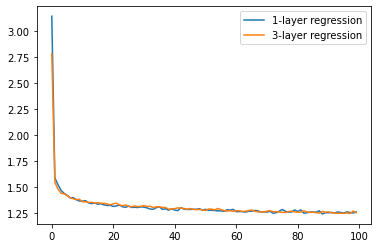

In [44]:
#Plot two loss and compare
plt.plot(totalloss_list1[:100], label="1-layer regression")
plt.plot(totalloss_list2[:100], label="3-layer regression")
plt.legend()

## Train Depth (1-layer Regression)

In [111]:
# Initialize vae to load trained vae
# Before run this, please be sure to run VAE class in chapter 3.

input_channels = 1 #depth has 1 
LATENT_CODE_NUM = 256
vae_depth = VAE(input_channels, latent_dim = LATENT_CODE_NUM).to(device)

In [112]:
#Load trained Depth-version VAE
vae_depth.load_state_dict(torch.load(
    "VAE_result_DepthImg_v1/VAE_result_depth_appro/VAE_800EPOCH.pkl", 
    map_location=torch.device('cpu')))

<All keys matched successfully>

In [60]:
#Read depth data, need to update path
DepthPATH = "generatedImagesSavedArray_v3_7Ori64p_addInitial/depth/"
#
#Initial
depth_initial1 = np.load(DepthPATH + "depth_array_list_initial_ori1.npy")
depth_initial2 = np.load(DepthPATH + "depth_array_list_initial_ori2.npy")
depth_initial3 = np.load(DepthPATH + "depth_array_list_initial_ori3.npy")
depth_initial4 = np.load(DepthPATH + "depth_array_list_initial_ori4.npy")
depth_initial5 = np.load(DepthPATH + "depth_array_list_initial_ori5.npy")
depth_initial6 = np.load(DepthPATH + "depth_array_list_initial_ori6.npy")
depth_initial7 = np.load(DepthPATH + "depth_array_list_initial_ori7.npy")

In [64]:
# Transform the numpy array to tensor
depth_initial = []
for i in range(len(depth_appro1)):
    depth_initial.append(torch.tensor(depth_initial1[i].reshape(1,64,64), dtype = torch.float32))   
    depth_initial.append(torch.tensor(depth_initial2[i].reshape(1,64,64), dtype = torch.float32))
    depth_initial.append(torch.tensor(depth_initial3[i].reshape(1,64,64), dtype = torch.float32))
    depth_initial.append(torch.tensor(depth_initial4[i].reshape(1,64,64), dtype = torch.float32))
    depth_initial.append(torch.tensor(depth_initial5[i].reshape(1,64,64), dtype = torch.float32))
    depth_initial.append(torch.tensor(depth_initial6[i].reshape(1,64,64), dtype = torch.float32))
    depth_initial.append(torch.tensor(depth_initial7[i].reshape(1,64,64), dtype = torch.float32))
    
depth_initial_64 = torch.stack((depth_appro) ,dim = 0)

In [65]:
depth_initial_64.shape

torch.Size([9751, 1, 64, 64])

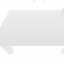

In [68]:
#Sample of showing the image
TF.to_pil_image(depth_initial_64[200])

In [69]:
#Encode initial state depth image
depth_encode = vae_depth.encode(depth_initial_64)

In [70]:
depth_encode[0].shape

torch.Size([9751, 256])

In [71]:
#stack mu and log_var
latent_depth = torch.cat((depth_encode[0], depth_encode[1]), dim = 1)
latent_depth = latent_depth.data

In [73]:
latent_depth.shape

torch.Size([9751, 512])

In [75]:
latent_depth

tensor([[-0.0003, -0.0002, -0.0001,  ..., -0.0002, -0.0003, -0.0002],
        [-0.0003, -0.0002, -0.0002,  ..., -0.0002, -0.0003, -0.0002],
        [-0.0003, -0.0002, -0.0001,  ..., -0.0002, -0.0003, -0.0002],
        ...,
        [-0.0003, -0.0002, -0.0001,  ..., -0.0002, -0.0003, -0.0002],
        [-0.0003, -0.0002, -0.0001,  ..., -0.0002, -0.0003, -0.0002],
        [-0.0003, -0.0002, -0.0002,  ..., -0.0002, -0.0003, -0.0002]])

In [80]:
#test decode from latent space
test_result = vae_depth.decode(vae_depth.reparameterize(latent_depth[200][:256], latent_depth[200][256:]))


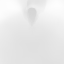

In [81]:
#Test OK
TF.to_pil_image(test_result[0])

In [87]:
# States, same as rgb
rgb_states_appro

tensor([[6.4409e-01, 1.8515e-01, 6.6092e-02,  ..., 4.3316e-09, 9.2409e-01,
         3.8218e-01],
        [6.4409e-01, 1.8515e-01, 6.6092e-02,  ..., 4.3316e-09, 9.2409e-01,
         3.8218e-01],
        [6.4409e-01, 1.8515e-01, 6.6092e-02,  ..., 4.3316e-09, 9.2409e-01,
         3.8218e-01],
        ...,
        [5.8677e-01, 7.9135e-04, 6.6092e-02,  ..., 1.9455e-12, 7.2918e-01,
         6.8432e-01],
        [5.8677e-01, 7.9135e-04, 6.6092e-02,  ..., 1.9455e-12, 7.2918e-01,
         6.8432e-01],
        [5.8677e-01, 7.9135e-04, 6.6092e-02,  ..., 1.9455e-12, 7.2918e-01,
         6.8432e-01]])

In [90]:
#Initialize the regression

regression = regressionNet(in_dim = 512, out_dim = 7).to(device)
# regression = regressionNet2(in_dim = 256, out_dim = 7).to(device)
optimizer = optim.Adam(regression.parameters(), lr = 0.005)
criterion = nn.MSELoss()

In [91]:
torch_dataset = Data.TensorDataset(latent_depth, rgb_states_appro)
train_loader = torch.utils.data.DataLoader(dataset = torch_dataset, num_workers = 2, 
                                           batch_size = 64, shuffle = True)

In [92]:
total_depth = trainRegression(0, 500)

Train Epoch:0 -- [0/9751 (0%)] -- Loss:0.188838
Train Epoch:0 -- [3200/9751 (33%)] -- Loss:0.076801
Train Epoch:0 -- [6400/9751 (65%)] -- Loss:0.031837
Train Epoch:0 -- [9600/9751 (98%)] -- Loss:0.013395
====> Epoch: 0 Average Loss:10.131543
Train Epoch:1 -- [0/9751 (0%)] -- Loss:0.020870
Train Epoch:1 -- [3200/9751 (33%)] -- Loss:0.009373
Train Epoch:1 -- [6400/9751 (65%)] -- Loss:0.018632
Train Epoch:1 -- [9600/9751 (98%)] -- Loss:0.017249
====> Epoch: 1 Average Loss:1.933327
Train Epoch:2 -- [0/9751 (0%)] -- Loss:0.006097
Train Epoch:2 -- [3200/9751 (33%)] -- Loss:0.010222
Train Epoch:2 -- [6400/9751 (65%)] -- Loss:0.025466
Train Epoch:2 -- [9600/9751 (98%)] -- Loss:0.012545
====> Epoch: 2 Average Loss:1.707744
Train Epoch:3 -- [0/9751 (0%)] -- Loss:0.011952
Train Epoch:3 -- [3200/9751 (33%)] -- Loss:0.011047
Train Epoch:3 -- [6400/9751 (65%)] -- Loss:0.007531
Train Epoch:3 -- [9600/9751 (98%)] -- Loss:0.010030
====> Epoch: 3 Average Loss:1.703377
Train Epoch:4 -- [0/9751 (0%)] -- L

Train Epoch:33 -- [9600/9751 (98%)] -- Loss:0.006413
====> Epoch: 33 Average Loss:1.707631
Train Epoch:34 -- [0/9751 (0%)] -- Loss:0.014301
Train Epoch:34 -- [3200/9751 (33%)] -- Loss:0.015243
Train Epoch:34 -- [6400/9751 (65%)] -- Loss:0.016118
Train Epoch:34 -- [9600/9751 (98%)] -- Loss:0.014826
====> Epoch: 34 Average Loss:1.702833
Train Epoch:35 -- [0/9751 (0%)] -- Loss:0.017883
Train Epoch:35 -- [3200/9751 (33%)] -- Loss:0.008554
Train Epoch:35 -- [6400/9751 (65%)] -- Loss:0.010996
Train Epoch:35 -- [9600/9751 (98%)] -- Loss:0.012153
====> Epoch: 35 Average Loss:1.708464
Train Epoch:36 -- [0/9751 (0%)] -- Loss:0.006657
Train Epoch:36 -- [3200/9751 (33%)] -- Loss:0.015651
Train Epoch:36 -- [6400/9751 (65%)] -- Loss:0.020362
Train Epoch:36 -- [9600/9751 (98%)] -- Loss:0.013100
====> Epoch: 36 Average Loss:1.716226
Train Epoch:37 -- [0/9751 (0%)] -- Loss:0.009655
Train Epoch:37 -- [3200/9751 (33%)] -- Loss:0.008718
Train Epoch:37 -- [6400/9751 (65%)] -- Loss:0.008080
Train Epoch:37 -

Train Epoch:67 -- [0/9751 (0%)] -- Loss:0.011022
Train Epoch:67 -- [3200/9751 (33%)] -- Loss:0.010410
Train Epoch:67 -- [6400/9751 (65%)] -- Loss:0.007543
Train Epoch:67 -- [9600/9751 (98%)] -- Loss:0.015716
====> Epoch: 67 Average Loss:1.708429
Train Epoch:68 -- [0/9751 (0%)] -- Loss:0.011126
Train Epoch:68 -- [3200/9751 (33%)] -- Loss:0.006299
Train Epoch:68 -- [6400/9751 (65%)] -- Loss:0.011943
Train Epoch:68 -- [9600/9751 (98%)] -- Loss:0.015748
====> Epoch: 68 Average Loss:1.704980
Train Epoch:69 -- [0/9751 (0%)] -- Loss:0.009734
Train Epoch:69 -- [3200/9751 (33%)] -- Loss:0.011732
Train Epoch:69 -- [6400/9751 (65%)] -- Loss:0.017974
Train Epoch:69 -- [9600/9751 (98%)] -- Loss:0.006615
====> Epoch: 69 Average Loss:1.698188
Train Epoch:70 -- [0/9751 (0%)] -- Loss:0.008350
Train Epoch:70 -- [3200/9751 (33%)] -- Loss:0.011352
Train Epoch:70 -- [6400/9751 (65%)] -- Loss:0.011118
Train Epoch:70 -- [9600/9751 (98%)] -- Loss:0.013356
====> Epoch: 70 Average Loss:1.697935
Train Epoch:71 -

Train Epoch:100 -- [6400/9751 (65%)] -- Loss:0.016448
Train Epoch:100 -- [9600/9751 (98%)] -- Loss:0.020552
====> Epoch: 100 Average Loss:1.692240
Train Epoch:101 -- [0/9751 (0%)] -- Loss:0.008036
Train Epoch:101 -- [3200/9751 (33%)] -- Loss:0.007117
Train Epoch:101 -- [6400/9751 (65%)] -- Loss:0.014083
Train Epoch:101 -- [9600/9751 (98%)] -- Loss:0.007214
====> Epoch: 101 Average Loss:1.704510
Train Epoch:102 -- [0/9751 (0%)] -- Loss:0.014899
Train Epoch:102 -- [3200/9751 (33%)] -- Loss:0.013257
Train Epoch:102 -- [6400/9751 (65%)] -- Loss:0.017032
Train Epoch:102 -- [9600/9751 (98%)] -- Loss:0.016520
====> Epoch: 102 Average Loss:1.701309
Train Epoch:103 -- [0/9751 (0%)] -- Loss:0.007304
Train Epoch:103 -- [3200/9751 (33%)] -- Loss:0.011740
Train Epoch:103 -- [6400/9751 (65%)] -- Loss:0.004926
Train Epoch:103 -- [9600/9751 (98%)] -- Loss:0.010019
====> Epoch: 103 Average Loss:1.692055
Train Epoch:104 -- [0/9751 (0%)] -- Loss:0.008777
Train Epoch:104 -- [3200/9751 (33%)] -- Loss:0.016

Train Epoch:133 -- [3200/9751 (33%)] -- Loss:0.007593
Train Epoch:133 -- [6400/9751 (65%)] -- Loss:0.012130
Train Epoch:133 -- [9600/9751 (98%)] -- Loss:0.009953
====> Epoch: 133 Average Loss:1.686134
Train Epoch:134 -- [0/9751 (0%)] -- Loss:0.008481
Train Epoch:134 -- [3200/9751 (33%)] -- Loss:0.017065
Train Epoch:134 -- [6400/9751 (65%)] -- Loss:0.011669
Train Epoch:134 -- [9600/9751 (98%)] -- Loss:0.008572
====> Epoch: 134 Average Loss:1.687006
Train Epoch:135 -- [0/9751 (0%)] -- Loss:0.018309
Train Epoch:135 -- [3200/9751 (33%)] -- Loss:0.008598
Train Epoch:135 -- [6400/9751 (65%)] -- Loss:0.004877
Train Epoch:135 -- [9600/9751 (98%)] -- Loss:0.022134
====> Epoch: 135 Average Loss:1.690449
Train Epoch:136 -- [0/9751 (0%)] -- Loss:0.011588
Train Epoch:136 -- [3200/9751 (33%)] -- Loss:0.006308
Train Epoch:136 -- [6400/9751 (65%)] -- Loss:0.010466
Train Epoch:136 -- [9600/9751 (98%)] -- Loss:0.009507
====> Epoch: 136 Average Loss:1.707732
Train Epoch:137 -- [0/9751 (0%)] -- Loss:0.013

Train Epoch:166 -- [0/9751 (0%)] -- Loss:0.009561
Train Epoch:166 -- [3200/9751 (33%)] -- Loss:0.012260
Train Epoch:166 -- [6400/9751 (65%)] -- Loss:0.010316
Train Epoch:166 -- [9600/9751 (98%)] -- Loss:0.006062
====> Epoch: 166 Average Loss:1.688446
Train Epoch:167 -- [0/9751 (0%)] -- Loss:0.008912
Train Epoch:167 -- [3200/9751 (33%)] -- Loss:0.013395
Train Epoch:167 -- [6400/9751 (65%)] -- Loss:0.009407
Train Epoch:167 -- [9600/9751 (98%)] -- Loss:0.005009
====> Epoch: 167 Average Loss:1.688886
Train Epoch:168 -- [0/9751 (0%)] -- Loss:0.015227
Train Epoch:168 -- [3200/9751 (33%)] -- Loss:0.011392
Train Epoch:168 -- [6400/9751 (65%)] -- Loss:0.005475
Train Epoch:168 -- [9600/9751 (98%)] -- Loss:0.015441
====> Epoch: 168 Average Loss:1.686430
Train Epoch:169 -- [0/9751 (0%)] -- Loss:0.012698
Train Epoch:169 -- [3200/9751 (33%)] -- Loss:0.010327
Train Epoch:169 -- [6400/9751 (65%)] -- Loss:0.013234
Train Epoch:169 -- [9600/9751 (98%)] -- Loss:0.008110
====> Epoch: 169 Average Loss:1.686

Train Epoch:199 -- [0/9751 (0%)] -- Loss:0.011596
Train Epoch:199 -- [3200/9751 (33%)] -- Loss:0.007415
Train Epoch:199 -- [6400/9751 (65%)] -- Loss:0.005998
Train Epoch:199 -- [9600/9751 (98%)] -- Loss:0.013357
====> Epoch: 199 Average Loss:1.686601
Train Epoch:200 -- [0/9751 (0%)] -- Loss:0.010868
Train Epoch:200 -- [3200/9751 (33%)] -- Loss:0.006639
Train Epoch:200 -- [6400/9751 (65%)] -- Loss:0.011358
Train Epoch:200 -- [9600/9751 (98%)] -- Loss:0.009740
====> Epoch: 200 Average Loss:1.690772
Train Epoch:201 -- [0/9751 (0%)] -- Loss:0.006442
Train Epoch:201 -- [3200/9751 (33%)] -- Loss:0.004769
Train Epoch:201 -- [6400/9751 (65%)] -- Loss:0.008054
Train Epoch:201 -- [9600/9751 (98%)] -- Loss:0.013235
====> Epoch: 201 Average Loss:1.691133
Train Epoch:202 -- [0/9751 (0%)] -- Loss:0.020958
Train Epoch:202 -- [3200/9751 (33%)] -- Loss:0.017599
Train Epoch:202 -- [6400/9751 (65%)] -- Loss:0.013915
Train Epoch:202 -- [9600/9751 (98%)] -- Loss:0.010192
====> Epoch: 202 Average Loss:1.682

====> Epoch: 231 Average Loss:1.686274
Train Epoch:232 -- [0/9751 (0%)] -- Loss:0.008842
Train Epoch:232 -- [3200/9751 (33%)] -- Loss:0.012402
Train Epoch:232 -- [6400/9751 (65%)] -- Loss:0.019022
Train Epoch:232 -- [9600/9751 (98%)] -- Loss:0.005174
====> Epoch: 232 Average Loss:1.681190
Train Epoch:233 -- [0/9751 (0%)] -- Loss:0.007522
Train Epoch:233 -- [3200/9751 (33%)] -- Loss:0.010198
Train Epoch:233 -- [6400/9751 (65%)] -- Loss:0.013394
Train Epoch:233 -- [9600/9751 (98%)] -- Loss:0.024451
====> Epoch: 233 Average Loss:1.682213
Train Epoch:234 -- [0/9751 (0%)] -- Loss:0.011571
Train Epoch:234 -- [3200/9751 (33%)] -- Loss:0.006011
Train Epoch:234 -- [6400/9751 (65%)] -- Loss:0.015642
Train Epoch:234 -- [9600/9751 (98%)] -- Loss:0.011742
====> Epoch: 234 Average Loss:1.687843
Train Epoch:235 -- [0/9751 (0%)] -- Loss:0.009397
Train Epoch:235 -- [3200/9751 (33%)] -- Loss:0.012281
Train Epoch:235 -- [6400/9751 (65%)] -- Loss:0.008946
Train Epoch:235 -- [9600/9751 (98%)] -- Loss:0.013

Train Epoch:264 -- [9600/9751 (98%)] -- Loss:0.014745
====> Epoch: 264 Average Loss:1.688441
Train Epoch:265 -- [0/9751 (0%)] -- Loss:0.013763
Train Epoch:265 -- [3200/9751 (33%)] -- Loss:0.014815
Train Epoch:265 -- [6400/9751 (65%)] -- Loss:0.009154
Train Epoch:265 -- [9600/9751 (98%)] -- Loss:0.011918
====> Epoch: 265 Average Loss:1.683149
Train Epoch:266 -- [0/9751 (0%)] -- Loss:0.007384
Train Epoch:266 -- [3200/9751 (33%)] -- Loss:0.014658
Train Epoch:266 -- [6400/9751 (65%)] -- Loss:0.015346
Train Epoch:266 -- [9600/9751 (98%)] -- Loss:0.009625
====> Epoch: 266 Average Loss:1.678327
Train Epoch:267 -- [0/9751 (0%)] -- Loss:0.012908
Train Epoch:267 -- [3200/9751 (33%)] -- Loss:0.011850
Train Epoch:267 -- [6400/9751 (65%)] -- Loss:0.005187
Train Epoch:267 -- [9600/9751 (98%)] -- Loss:0.007365
====> Epoch: 267 Average Loss:1.677012
Train Epoch:268 -- [0/9751 (0%)] -- Loss:0.008892
Train Epoch:268 -- [3200/9751 (33%)] -- Loss:0.013146
Train Epoch:268 -- [6400/9751 (65%)] -- Loss:0.013

Train Epoch:297 -- [6400/9751 (65%)] -- Loss:0.017287
Train Epoch:297 -- [9600/9751 (98%)] -- Loss:0.005518
====> Epoch: 297 Average Loss:1.675147
Train Epoch:298 -- [0/9751 (0%)] -- Loss:0.006133
Train Epoch:298 -- [3200/9751 (33%)] -- Loss:0.010687
Train Epoch:298 -- [6400/9751 (65%)] -- Loss:0.020580
Train Epoch:298 -- [9600/9751 (98%)] -- Loss:0.005937
====> Epoch: 298 Average Loss:1.673978
Train Epoch:299 -- [0/9751 (0%)] -- Loss:0.004210
Train Epoch:299 -- [3200/9751 (33%)] -- Loss:0.014440
Train Epoch:299 -- [6400/9751 (65%)] -- Loss:0.005807
Train Epoch:299 -- [9600/9751 (98%)] -- Loss:0.015918
====> Epoch: 299 Average Loss:1.674742
Train Epoch:300 -- [0/9751 (0%)] -- Loss:0.009692
Train Epoch:300 -- [3200/9751 (33%)] -- Loss:0.012869
Train Epoch:300 -- [6400/9751 (65%)] -- Loss:0.012123
Train Epoch:300 -- [9600/9751 (98%)] -- Loss:0.010732
====> Epoch: 300 Average Loss:1.673510
Train Epoch:301 -- [0/9751 (0%)] -- Loss:0.008946
Train Epoch:301 -- [3200/9751 (33%)] -- Loss:0.008

Train Epoch:330 -- [3200/9751 (33%)] -- Loss:0.006864
Train Epoch:330 -- [6400/9751 (65%)] -- Loss:0.006483
Train Epoch:330 -- [9600/9751 (98%)] -- Loss:0.005306
====> Epoch: 330 Average Loss:1.677495
Train Epoch:331 -- [0/9751 (0%)] -- Loss:0.021997
Train Epoch:331 -- [3200/9751 (33%)] -- Loss:0.006540
Train Epoch:331 -- [6400/9751 (65%)] -- Loss:0.015378
Train Epoch:331 -- [9600/9751 (98%)] -- Loss:0.006644
====> Epoch: 331 Average Loss:1.680140
Train Epoch:332 -- [0/9751 (0%)] -- Loss:0.017040
Train Epoch:332 -- [3200/9751 (33%)] -- Loss:0.009980
Train Epoch:332 -- [6400/9751 (65%)] -- Loss:0.010851
Train Epoch:332 -- [9600/9751 (98%)] -- Loss:0.008330
====> Epoch: 332 Average Loss:1.672275
Train Epoch:333 -- [0/9751 (0%)] -- Loss:0.005653
Train Epoch:333 -- [3200/9751 (33%)] -- Loss:0.013708
Train Epoch:333 -- [6400/9751 (65%)] -- Loss:0.005609
Train Epoch:333 -- [9600/9751 (98%)] -- Loss:0.007826
====> Epoch: 333 Average Loss:1.674685
Train Epoch:334 -- [0/9751 (0%)] -- Loss:0.012

Train Epoch:363 -- [0/9751 (0%)] -- Loss:0.007069
Train Epoch:363 -- [3200/9751 (33%)] -- Loss:0.007704
Train Epoch:363 -- [6400/9751 (65%)] -- Loss:0.006181
Train Epoch:363 -- [9600/9751 (98%)] -- Loss:0.009802
====> Epoch: 363 Average Loss:1.672148
Train Epoch:364 -- [0/9751 (0%)] -- Loss:0.015714
Train Epoch:364 -- [3200/9751 (33%)] -- Loss:0.016021
Train Epoch:364 -- [6400/9751 (65%)] -- Loss:0.008102
Train Epoch:364 -- [9600/9751 (98%)] -- Loss:0.011478
====> Epoch: 364 Average Loss:1.673478
Train Epoch:365 -- [0/9751 (0%)] -- Loss:0.010173
Train Epoch:365 -- [3200/9751 (33%)] -- Loss:0.007192
Train Epoch:365 -- [6400/9751 (65%)] -- Loss:0.012263
Train Epoch:365 -- [9600/9751 (98%)] -- Loss:0.021766
====> Epoch: 365 Average Loss:1.680083
Train Epoch:366 -- [0/9751 (0%)] -- Loss:0.009875
Train Epoch:366 -- [3200/9751 (33%)] -- Loss:0.013853
Train Epoch:366 -- [6400/9751 (65%)] -- Loss:0.006224
Train Epoch:366 -- [9600/9751 (98%)] -- Loss:0.016695
====> Epoch: 366 Average Loss:1.675

Train Epoch:396 -- [0/9751 (0%)] -- Loss:0.011291
Train Epoch:396 -- [3200/9751 (33%)] -- Loss:0.015230
Train Epoch:396 -- [6400/9751 (65%)] -- Loss:0.012399
Train Epoch:396 -- [9600/9751 (98%)] -- Loss:0.013353
====> Epoch: 396 Average Loss:1.681654
Train Epoch:397 -- [0/9751 (0%)] -- Loss:0.007140
Train Epoch:397 -- [3200/9751 (33%)] -- Loss:0.012111
Train Epoch:397 -- [6400/9751 (65%)] -- Loss:0.021842
Train Epoch:397 -- [9600/9751 (98%)] -- Loss:0.007340
====> Epoch: 397 Average Loss:1.668365
Train Epoch:398 -- [0/9751 (0%)] -- Loss:0.010706
Train Epoch:398 -- [3200/9751 (33%)] -- Loss:0.007691
Train Epoch:398 -- [6400/9751 (65%)] -- Loss:0.013141
Train Epoch:398 -- [9600/9751 (98%)] -- Loss:0.006654
====> Epoch: 398 Average Loss:1.672438
Train Epoch:399 -- [0/9751 (0%)] -- Loss:0.012674
Train Epoch:399 -- [3200/9751 (33%)] -- Loss:0.008193
Train Epoch:399 -- [6400/9751 (65%)] -- Loss:0.014009
Train Epoch:399 -- [9600/9751 (98%)] -- Loss:0.011627
====> Epoch: 399 Average Loss:1.668

Train Epoch:429 -- [0/9751 (0%)] -- Loss:0.004752
Train Epoch:429 -- [3200/9751 (33%)] -- Loss:0.005485
Train Epoch:429 -- [6400/9751 (65%)] -- Loss:0.008799
Train Epoch:429 -- [9600/9751 (98%)] -- Loss:0.017772
====> Epoch: 429 Average Loss:1.671717
Train Epoch:430 -- [0/9751 (0%)] -- Loss:0.006936
Train Epoch:430 -- [3200/9751 (33%)] -- Loss:0.007960
Train Epoch:430 -- [6400/9751 (65%)] -- Loss:0.007363
Train Epoch:430 -- [9600/9751 (98%)] -- Loss:0.007938
====> Epoch: 430 Average Loss:1.669899
Train Epoch:431 -- [0/9751 (0%)] -- Loss:0.017210
Train Epoch:431 -- [3200/9751 (33%)] -- Loss:0.005602
Train Epoch:431 -- [6400/9751 (65%)] -- Loss:0.007567
Train Epoch:431 -- [9600/9751 (98%)] -- Loss:0.006057
====> Epoch: 431 Average Loss:1.668418
Train Epoch:432 -- [0/9751 (0%)] -- Loss:0.013854
Train Epoch:432 -- [3200/9751 (33%)] -- Loss:0.009430
Train Epoch:432 -- [6400/9751 (65%)] -- Loss:0.010945
Train Epoch:432 -- [9600/9751 (98%)] -- Loss:0.009033
====> Epoch: 432 Average Loss:1.679

Train Epoch:462 -- [0/9751 (0%)] -- Loss:0.010664
Train Epoch:462 -- [3200/9751 (33%)] -- Loss:0.011691
Train Epoch:462 -- [6400/9751 (65%)] -- Loss:0.008271
Train Epoch:462 -- [9600/9751 (98%)] -- Loss:0.012677
====> Epoch: 462 Average Loss:1.665683
Train Epoch:463 -- [0/9751 (0%)] -- Loss:0.012585
Train Epoch:463 -- [3200/9751 (33%)] -- Loss:0.008220
Train Epoch:463 -- [6400/9751 (65%)] -- Loss:0.011583
Train Epoch:463 -- [9600/9751 (98%)] -- Loss:0.015348
====> Epoch: 463 Average Loss:1.667285
Train Epoch:464 -- [0/9751 (0%)] -- Loss:0.025032
Train Epoch:464 -- [3200/9751 (33%)] -- Loss:0.006318
Train Epoch:464 -- [6400/9751 (65%)] -- Loss:0.004726
Train Epoch:464 -- [9600/9751 (98%)] -- Loss:0.006529
====> Epoch: 464 Average Loss:1.684273
Train Epoch:465 -- [0/9751 (0%)] -- Loss:0.011668
Train Epoch:465 -- [3200/9751 (33%)] -- Loss:0.014155
Train Epoch:465 -- [6400/9751 (65%)] -- Loss:0.012064
Train Epoch:465 -- [9600/9751 (98%)] -- Loss:0.013158
====> Epoch: 465 Average Loss:1.670

Train Epoch:495 -- [0/9751 (0%)] -- Loss:0.010958
Train Epoch:495 -- [3200/9751 (33%)] -- Loss:0.021624
Train Epoch:495 -- [6400/9751 (65%)] -- Loss:0.011009
Train Epoch:495 -- [9600/9751 (98%)] -- Loss:0.011515
====> Epoch: 495 Average Loss:1.678561
Train Epoch:496 -- [0/9751 (0%)] -- Loss:0.009562
Train Epoch:496 -- [3200/9751 (33%)] -- Loss:0.007256
Train Epoch:496 -- [6400/9751 (65%)] -- Loss:0.010819
Train Epoch:496 -- [9600/9751 (98%)] -- Loss:0.004978
====> Epoch: 496 Average Loss:1.664619
Train Epoch:497 -- [0/9751 (0%)] -- Loss:0.006863
Train Epoch:497 -- [3200/9751 (33%)] -- Loss:0.009316
Train Epoch:497 -- [6400/9751 (65%)] -- Loss:0.025084
Train Epoch:497 -- [9600/9751 (98%)] -- Loss:0.017154
====> Epoch: 497 Average Loss:1.666319
Train Epoch:498 -- [0/9751 (0%)] -- Loss:0.015175
Train Epoch:498 -- [3200/9751 (33%)] -- Loss:0.010237
Train Epoch:498 -- [6400/9751 (65%)] -- Loss:0.006223
Train Epoch:498 -- [9600/9751 (98%)] -- Loss:0.014858
====> Epoch: 498 Average Loss:1.667

In [93]:
total_depthloss = np.load("regressionResult/Depth/Regression_depthloss_500.npy")

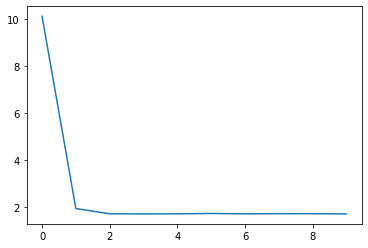

In [95]:
plt.plot(total_depthloss[:10])

## Train RGB-D (1-layer Regression)

In [109]:
# Initialize vae to load trained vae
# Before run this, please be sure to run VAE class in chapter 3.

input_channels = 4 #RGBD has 4
LATENT_CODE_NUM = 128
vae_rgbd = VAE(input_channels, latent_dim = LATENT_CODE_NUM).to(device)

In [110]:
#Load trained RGBD-version VAE
vae_rgbd.load_state_dict(torch.load(
    "VAE_result_RGBD_v1/VAE_RGBD_result_appro/VAE_500EPOCH.pkl", 
    map_location=torch.device('cpu')))

<All keys matched successfully>

In [99]:
def loadRGBD(behavior):
    rgbPATH = "generatedImagesSavedArray_v3_7Ori64p_addInitial/rgb/"
    depthPATH = "generatedImagesSavedArray_v3_7Ori64p_addInitial/depth/"
    
    rgb_appro1 = np.load(rgbPATH + "rgb_array_list_" + str(behavior) + "_ori1.npy")
    rgb_appro2 = np.load(rgbPATH + "rgb_array_list_" + str(behavior) + "_ori2.npy")
    rgb_appro3 = np.load(rgbPATH + "rgb_array_list_" + str(behavior) + "_ori3.npy")
    rgb_appro4 = np.load(rgbPATH + "rgb_array_list_" + str(behavior) + "_ori4.npy")
    rgb_appro5 = np.load(rgbPATH + "rgb_array_list_" + str(behavior) + "_ori5.npy")
    rgb_appro6 = np.load(rgbPATH + "rgb_array_list_" + str(behavior) + "_ori6.npy")
    rgb_appro7 = np.load(rgbPATH + "rgb_array_list_" + str(behavior) + "_ori7.npy")

    depth_appro1 = np.load(depthPATH + "depth_array_list_" + str(behavior) + "_ori1.npy")
    depth_appro2 = np.load(depthPATH + "depth_array_list_" + str(behavior) + "_ori2.npy")
    depth_appro3 = np.load(depthPATH + "depth_array_list_" + str(behavior) + "_ori3.npy")
    depth_appro4 = np.load(depthPATH + "depth_array_list_" + str(behavior) + "_ori4.npy")
    depth_appro5 = np.load(depthPATH + "depth_array_list_" + str(behavior) + "_ori5.npy")
    depth_appro6 = np.load(depthPATH + "depth_array_list_" + str(behavior) + "_ori6.npy")
    depth_appro7 = np.load(depthPATH + "depth_array_list_" + str(behavior) + "_ori7.npy")
    
    rgb_appro = []
    for i in range(len(rgb_appro1)):
        rgb_appro.append(TF.to_tensor(rgb_appro1[i]))   
        rgb_appro.append(TF.to_tensor(rgb_appro2[i]))
        rgb_appro.append(TF.to_tensor(rgb_appro3[i]))
        rgb_appro.append(TF.to_tensor(rgb_appro4[i]))
        rgb_appro.append(TF.to_tensor(rgb_appro5[i]))
        rgb_appro.append(TF.to_tensor(rgb_appro6[i]))
        rgb_appro.append(TF.to_tensor(rgb_appro7[i]))
    
    depth_appro = []
    for i in range(len(depth_appro1)):
        depth_appro.append(torch.tensor(depth_appro1[i].reshape(64,64), dtype = torch.float32))   
        depth_appro.append(torch.tensor(depth_appro2[i].reshape(64,64), dtype = torch.float32))
        depth_appro.append(torch.tensor(depth_appro3[i].reshape(64,64), dtype = torch.float32))
        depth_appro.append(torch.tensor(depth_appro4[i].reshape(64,64), dtype = torch.float32))
        depth_appro.append(torch.tensor(depth_appro5[i].reshape(64,64), dtype = torch.float32))
        depth_appro.append(torch.tensor(depth_appro6[i].reshape(64,64), dtype = torch.float32))
        depth_appro.append(torch.tensor(depth_appro7[i].reshape(64,64), dtype = torch.float32))
        
    rgb_d = []
    for i in range(len(rgb_appro)):
        rgb_d.append(torch.stack((rgb_appro[i][0], rgb_appro[i][1], 
                                  rgb_appro[i][2], depth_appro[i]) ,dim = 0))

    
    
    return torch.stack(rgb_d)

In [100]:
rgbd_initial = loadRGBD('initial')

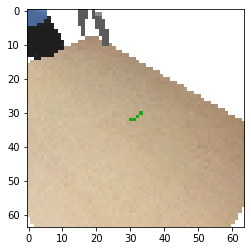

In [101]:
#RGB images

plt.imshow(rgbd_initial[113][:3].permute(1,2,0))

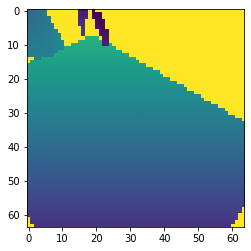

In [102]:
#Depth Images

plt.imshow(rgbd_initial[113][3])

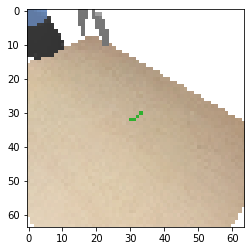

In [103]:
#RGBD Images

plt.imshow(rgbd_initial[113].permute(1,2,0))

In [104]:
rgbd_initial.shape

torch.Size([9751, 4, 64, 64])

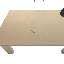

In [105]:
#Sample of showing
TF.to_pil_image(rgbd_initial[200])

In [114]:
#Encode initial state depth image
rgbd_encode = vae_rgbd.encode(rgbd_initial)

In [115]:
rgbd_encode[0].shape

torch.Size([9751, 128])

In [117]:
#stack mu and log_var
latent_rgbd = torch.cat((rgbd_encode[0], rgbd_encode[1]), dim = 1)
latent_rgbd = latent_rgbd.data

In [118]:
latent_rgbd.shape

torch.Size([9751, 256])

In [119]:
latent_rgbd

tensor([[-0.0035,  0.0454, -0.0072,  ..., -0.2751,  0.0325, -0.0125],
        [-0.0089,  0.0264,  0.0344,  ..., -0.2064,  0.0754,  0.0573],
        [ 0.0569,  0.1313, -0.0838,  ...,  0.0230,  0.1086,  0.0448],
        ...,
        [-0.0156, -0.0321, -0.0142,  ...,  0.0047,  0.0224,  0.0111],
        [-0.0223, -0.0372, -0.0275,  ..., -0.0548,  0.0803, -0.0266],
        [-0.0500,  0.0183,  0.0804,  ...,  0.0154,  0.0717,  0.0046]])

In [120]:
#test decode from latent space
test_result = vae_rgbd.decode(vae_rgbd.reparameterize(latent_rgbd[200][:128], latent_rgbd[200][128:]))


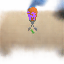

In [121]:
#Test OK
TF.to_pil_image(test_result[0])

In [122]:
# States, same as rgb
rgb_states_appro

tensor([[6.4409e-01, 1.8515e-01, 6.6092e-02,  ..., 4.3316e-09, 9.2409e-01,
         3.8218e-01],
        [6.4409e-01, 1.8515e-01, 6.6092e-02,  ..., 4.3316e-09, 9.2409e-01,
         3.8218e-01],
        [6.4409e-01, 1.8515e-01, 6.6092e-02,  ..., 4.3316e-09, 9.2409e-01,
         3.8218e-01],
        ...,
        [5.8677e-01, 7.9135e-04, 6.6092e-02,  ..., 1.9455e-12, 7.2918e-01,
         6.8432e-01],
        [5.8677e-01, 7.9135e-04, 6.6092e-02,  ..., 1.9455e-12, 7.2918e-01,
         6.8432e-01],
        [5.8677e-01, 7.9135e-04, 6.6092e-02,  ..., 1.9455e-12, 7.2918e-01,
         6.8432e-01]])

In [125]:
#Initialize the regression

regression = regressionNet(in_dim = 256, out_dim = 7).to(device)
optimizer = optim.Adam(regression.parameters(), lr = 0.005)
criterion = nn.MSELoss()

In [126]:
regression

regressionNet(
  (layer1): Linear(in_features=256, out_features=7, bias=True)
)

In [127]:
torch_dataset = Data.TensorDataset(latent_rgbd, rgb_states_appro)
train_loader = torch.utils.data.DataLoader(dataset = torch_dataset, num_workers = 2, 
                                           batch_size = 64, shuffle = True)

In [128]:
total_rgbd = trainRegression(0, 500)

Train Epoch:0 -- [0/9751 (0%)] -- Loss:0.175753
Train Epoch:0 -- [3200/9751 (33%)] -- Loss:0.018738
Train Epoch:0 -- [6400/9751 (65%)] -- Loss:0.014644
Train Epoch:0 -- [9600/9751 (98%)] -- Loss:0.010406
====> Epoch: 0 Average Loss:3.008172
Train Epoch:1 -- [0/9751 (0%)] -- Loss:0.018967
Train Epoch:1 -- [3200/9751 (33%)] -- Loss:0.010045
Train Epoch:1 -- [6400/9751 (65%)] -- Loss:0.008649
Train Epoch:1 -- [9600/9751 (98%)] -- Loss:0.021003
====> Epoch: 1 Average Loss:1.527627
Train Epoch:2 -- [0/9751 (0%)] -- Loss:0.010229
Train Epoch:2 -- [3200/9751 (33%)] -- Loss:0.008726
Train Epoch:2 -- [6400/9751 (65%)] -- Loss:0.008770
Train Epoch:2 -- [9600/9751 (98%)] -- Loss:0.012147
====> Epoch: 2 Average Loss:1.485898
Train Epoch:3 -- [0/9751 (0%)] -- Loss:0.016005
Train Epoch:3 -- [3200/9751 (33%)] -- Loss:0.008540
Train Epoch:3 -- [6400/9751 (65%)] -- Loss:0.008471
Train Epoch:3 -- [9600/9751 (98%)] -- Loss:0.009255
====> Epoch: 3 Average Loss:1.452238
Train Epoch:4 -- [0/9751 (0%)] -- Lo

Train Epoch:33 -- [9600/9751 (98%)] -- Loss:0.010827
====> Epoch: 33 Average Loss:1.323243
Train Epoch:34 -- [0/9751 (0%)] -- Loss:0.005024
Train Epoch:34 -- [3200/9751 (33%)] -- Loss:0.007271
Train Epoch:34 -- [6400/9751 (65%)] -- Loss:0.008963
Train Epoch:34 -- [9600/9751 (98%)] -- Loss:0.005514
====> Epoch: 34 Average Loss:1.331266
Train Epoch:35 -- [0/9751 (0%)] -- Loss:0.009021
Train Epoch:35 -- [3200/9751 (33%)] -- Loss:0.015109
Train Epoch:35 -- [6400/9751 (65%)] -- Loss:0.007853
Train Epoch:35 -- [9600/9751 (98%)] -- Loss:0.006755
====> Epoch: 35 Average Loss:1.327153
Train Epoch:36 -- [0/9751 (0%)] -- Loss:0.008829
Train Epoch:36 -- [3200/9751 (33%)] -- Loss:0.007262
Train Epoch:36 -- [6400/9751 (65%)] -- Loss:0.007941
Train Epoch:36 -- [9600/9751 (98%)] -- Loss:0.008634
====> Epoch: 36 Average Loss:1.330754
Train Epoch:37 -- [0/9751 (0%)] -- Loss:0.009741
Train Epoch:37 -- [3200/9751 (33%)] -- Loss:0.008810
Train Epoch:37 -- [6400/9751 (65%)] -- Loss:0.010821
Train Epoch:37 -

Train Epoch:67 -- [0/9751 (0%)] -- Loss:0.007461
Train Epoch:67 -- [3200/9751 (33%)] -- Loss:0.005489
Train Epoch:67 -- [6400/9751 (65%)] -- Loss:0.007219
Train Epoch:67 -- [9600/9751 (98%)] -- Loss:0.009212
====> Epoch: 67 Average Loss:1.314550
Train Epoch:68 -- [0/9751 (0%)] -- Loss:0.010824
Train Epoch:68 -- [3200/9751 (33%)] -- Loss:0.005291
Train Epoch:68 -- [6400/9751 (65%)] -- Loss:0.009322
Train Epoch:68 -- [9600/9751 (98%)] -- Loss:0.014238
====> Epoch: 68 Average Loss:1.307267
Train Epoch:69 -- [0/9751 (0%)] -- Loss:0.010575
Train Epoch:69 -- [3200/9751 (33%)] -- Loss:0.004801
Train Epoch:69 -- [6400/9751 (65%)] -- Loss:0.006769
Train Epoch:69 -- [9600/9751 (98%)] -- Loss:0.007158
====> Epoch: 69 Average Loss:1.310974
Train Epoch:70 -- [0/9751 (0%)] -- Loss:0.006976
Train Epoch:70 -- [3200/9751 (33%)] -- Loss:0.005430
Train Epoch:70 -- [6400/9751 (65%)] -- Loss:0.015109
Train Epoch:70 -- [9600/9751 (98%)] -- Loss:0.007817
====> Epoch: 70 Average Loss:1.303081
Train Epoch:71 -

Train Epoch:100 -- [6400/9751 (65%)] -- Loss:0.006755
Train Epoch:100 -- [9600/9751 (98%)] -- Loss:0.010296
====> Epoch: 100 Average Loss:1.290079
Train Epoch:101 -- [0/9751 (0%)] -- Loss:0.004433
Train Epoch:101 -- [3200/9751 (33%)] -- Loss:0.006549
Train Epoch:101 -- [6400/9751 (65%)] -- Loss:0.005407
Train Epoch:101 -- [9600/9751 (98%)] -- Loss:0.006039
====> Epoch: 101 Average Loss:1.285304
Train Epoch:102 -- [0/9751 (0%)] -- Loss:0.005944
Train Epoch:102 -- [3200/9751 (33%)] -- Loss:0.008579
Train Epoch:102 -- [6400/9751 (65%)] -- Loss:0.008774
Train Epoch:102 -- [9600/9751 (98%)] -- Loss:0.006259
====> Epoch: 102 Average Loss:1.297625
Train Epoch:103 -- [0/9751 (0%)] -- Loss:0.009110
Train Epoch:103 -- [3200/9751 (33%)] -- Loss:0.012109
Train Epoch:103 -- [6400/9751 (65%)] -- Loss:0.007995
Train Epoch:103 -- [9600/9751 (98%)] -- Loss:0.008032
====> Epoch: 103 Average Loss:1.289146
Train Epoch:104 -- [0/9751 (0%)] -- Loss:0.008686
Train Epoch:104 -- [3200/9751 (33%)] -- Loss:0.005

Train Epoch:133 -- [3200/9751 (33%)] -- Loss:0.008227
Train Epoch:133 -- [6400/9751 (65%)] -- Loss:0.006685
Train Epoch:133 -- [9600/9751 (98%)] -- Loss:0.007899
====> Epoch: 133 Average Loss:1.283637
Train Epoch:134 -- [0/9751 (0%)] -- Loss:0.009850
Train Epoch:134 -- [3200/9751 (33%)] -- Loss:0.007215
Train Epoch:134 -- [6400/9751 (65%)] -- Loss:0.008330
Train Epoch:134 -- [9600/9751 (98%)] -- Loss:0.006878
====> Epoch: 134 Average Loss:1.291898
Train Epoch:135 -- [0/9751 (0%)] -- Loss:0.011134
Train Epoch:135 -- [3200/9751 (33%)] -- Loss:0.004659
Train Epoch:135 -- [6400/9751 (65%)] -- Loss:0.009138
Train Epoch:135 -- [9600/9751 (98%)] -- Loss:0.006146
====> Epoch: 135 Average Loss:1.277951
Train Epoch:136 -- [0/9751 (0%)] -- Loss:0.005415
Train Epoch:136 -- [3200/9751 (33%)] -- Loss:0.008950
Train Epoch:136 -- [6400/9751 (65%)] -- Loss:0.008636
Train Epoch:136 -- [9600/9751 (98%)] -- Loss:0.006477
====> Epoch: 136 Average Loss:1.293205
Train Epoch:137 -- [0/9751 (0%)] -- Loss:0.012

Train Epoch:166 -- [0/9751 (0%)] -- Loss:0.006936
Train Epoch:166 -- [3200/9751 (33%)] -- Loss:0.009185
Train Epoch:166 -- [6400/9751 (65%)] -- Loss:0.008315
Train Epoch:166 -- [9600/9751 (98%)] -- Loss:0.009212
====> Epoch: 166 Average Loss:1.286314
Train Epoch:167 -- [0/9751 (0%)] -- Loss:0.008574
Train Epoch:167 -- [3200/9751 (33%)] -- Loss:0.014940
Train Epoch:167 -- [6400/9751 (65%)] -- Loss:0.017224
Train Epoch:167 -- [9600/9751 (98%)] -- Loss:0.008031
====> Epoch: 167 Average Loss:1.286872
Train Epoch:168 -- [0/9751 (0%)] -- Loss:0.006832
Train Epoch:168 -- [3200/9751 (33%)] -- Loss:0.006108
Train Epoch:168 -- [6400/9751 (65%)] -- Loss:0.009173
Train Epoch:168 -- [9600/9751 (98%)] -- Loss:0.005947
====> Epoch: 168 Average Loss:1.282476
Train Epoch:169 -- [0/9751 (0%)] -- Loss:0.010727
Train Epoch:169 -- [3200/9751 (33%)] -- Loss:0.005591
Train Epoch:169 -- [6400/9751 (65%)] -- Loss:0.008936
Train Epoch:169 -- [9600/9751 (98%)] -- Loss:0.004504
====> Epoch: 169 Average Loss:1.278

Train Epoch:199 -- [0/9751 (0%)] -- Loss:0.010175
Train Epoch:199 -- [3200/9751 (33%)] -- Loss:0.008356
Train Epoch:199 -- [6400/9751 (65%)] -- Loss:0.011188
Train Epoch:199 -- [9600/9751 (98%)] -- Loss:0.007862
====> Epoch: 199 Average Loss:1.271970
Train Epoch:200 -- [0/9751 (0%)] -- Loss:0.004408
Train Epoch:200 -- [3200/9751 (33%)] -- Loss:0.005115
Train Epoch:200 -- [6400/9751 (65%)] -- Loss:0.008083
Train Epoch:200 -- [9600/9751 (98%)] -- Loss:0.007956
====> Epoch: 200 Average Loss:1.273595
Train Epoch:201 -- [0/9751 (0%)] -- Loss:0.006438
Train Epoch:201 -- [3200/9751 (33%)] -- Loss:0.005358
Train Epoch:201 -- [6400/9751 (65%)] -- Loss:0.007212
Train Epoch:201 -- [9600/9751 (98%)] -- Loss:0.009741
====> Epoch: 201 Average Loss:1.285785
Train Epoch:202 -- [0/9751 (0%)] -- Loss:0.008058
Train Epoch:202 -- [3200/9751 (33%)] -- Loss:0.009098
Train Epoch:202 -- [6400/9751 (65%)] -- Loss:0.006330
Train Epoch:202 -- [9600/9751 (98%)] -- Loss:0.006935
====> Epoch: 202 Average Loss:1.279

Train Epoch:232 -- [0/9751 (0%)] -- Loss:0.007873
Train Epoch:232 -- [3200/9751 (33%)] -- Loss:0.015445
Train Epoch:232 -- [6400/9751 (65%)] -- Loss:0.007790
Train Epoch:232 -- [9600/9751 (98%)] -- Loss:0.010071
====> Epoch: 232 Average Loss:1.281217
Train Epoch:233 -- [0/9751 (0%)] -- Loss:0.006008
Train Epoch:233 -- [3200/9751 (33%)] -- Loss:0.005396
Train Epoch:233 -- [6400/9751 (65%)] -- Loss:0.007609
Train Epoch:233 -- [9600/9751 (98%)] -- Loss:0.004790
====> Epoch: 233 Average Loss:1.262796
Train Epoch:234 -- [0/9751 (0%)] -- Loss:0.005672
Train Epoch:234 -- [3200/9751 (33%)] -- Loss:0.004730
Train Epoch:234 -- [6400/9751 (65%)] -- Loss:0.004507
Train Epoch:234 -- [9600/9751 (98%)] -- Loss:0.006674
====> Epoch: 234 Average Loss:1.267117
Train Epoch:235 -- [0/9751 (0%)] -- Loss:0.012884
Train Epoch:235 -- [3200/9751 (33%)] -- Loss:0.005531
Train Epoch:235 -- [6400/9751 (65%)] -- Loss:0.010791
Train Epoch:235 -- [9600/9751 (98%)] -- Loss:0.004432
====> Epoch: 235 Average Loss:1.271

Train Epoch:265 -- [0/9751 (0%)] -- Loss:0.009958
Train Epoch:265 -- [3200/9751 (33%)] -- Loss:0.012530
Train Epoch:265 -- [6400/9751 (65%)] -- Loss:0.005066
Train Epoch:265 -- [9600/9751 (98%)] -- Loss:0.004894
====> Epoch: 265 Average Loss:1.276393
Train Epoch:266 -- [0/9751 (0%)] -- Loss:0.005995
Train Epoch:266 -- [3200/9751 (33%)] -- Loss:0.011868
Train Epoch:266 -- [6400/9751 (65%)] -- Loss:0.006926
Train Epoch:266 -- [9600/9751 (98%)] -- Loss:0.005906
====> Epoch: 266 Average Loss:1.276900
Train Epoch:267 -- [0/9751 (0%)] -- Loss:0.004794
Train Epoch:267 -- [3200/9751 (33%)] -- Loss:0.007923
Train Epoch:267 -- [6400/9751 (65%)] -- Loss:0.012412
Train Epoch:267 -- [9600/9751 (98%)] -- Loss:0.015872
====> Epoch: 267 Average Loss:1.265837
Train Epoch:268 -- [0/9751 (0%)] -- Loss:0.008175
Train Epoch:268 -- [3200/9751 (33%)] -- Loss:0.013062
Train Epoch:268 -- [6400/9751 (65%)] -- Loss:0.007219
Train Epoch:268 -- [9600/9751 (98%)] -- Loss:0.006247
====> Epoch: 268 Average Loss:1.284

Train Epoch:298 -- [0/9751 (0%)] -- Loss:0.011193
Train Epoch:298 -- [3200/9751 (33%)] -- Loss:0.008040
Train Epoch:298 -- [6400/9751 (65%)] -- Loss:0.006388
Train Epoch:298 -- [9600/9751 (98%)] -- Loss:0.010842
====> Epoch: 298 Average Loss:1.269342
Train Epoch:299 -- [0/9751 (0%)] -- Loss:0.011494
Train Epoch:299 -- [3200/9751 (33%)] -- Loss:0.011062
Train Epoch:299 -- [6400/9751 (65%)] -- Loss:0.006800
Train Epoch:299 -- [9600/9751 (98%)] -- Loss:0.009238
====> Epoch: 299 Average Loss:1.273695
Train Epoch:300 -- [0/9751 (0%)] -- Loss:0.008357
Train Epoch:300 -- [3200/9751 (33%)] -- Loss:0.009205
Train Epoch:300 -- [6400/9751 (65%)] -- Loss:0.006649
Train Epoch:300 -- [9600/9751 (98%)] -- Loss:0.010664
====> Epoch: 300 Average Loss:1.272125
Train Epoch:301 -- [0/9751 (0%)] -- Loss:0.004740
Train Epoch:301 -- [3200/9751 (33%)] -- Loss:0.012593
Train Epoch:301 -- [6400/9751 (65%)] -- Loss:0.004027
Train Epoch:301 -- [9600/9751 (98%)] -- Loss:0.008760
====> Epoch: 301 Average Loss:1.266

Train Epoch:331 -- [0/9751 (0%)] -- Loss:0.004431
Train Epoch:331 -- [3200/9751 (33%)] -- Loss:0.004694
Train Epoch:331 -- [6400/9751 (65%)] -- Loss:0.007292
Train Epoch:331 -- [9600/9751 (98%)] -- Loss:0.010335
====> Epoch: 331 Average Loss:1.276095
Train Epoch:332 -- [0/9751 (0%)] -- Loss:0.008044
Train Epoch:332 -- [3200/9751 (33%)] -- Loss:0.004936
Train Epoch:332 -- [6400/9751 (65%)] -- Loss:0.010366
Train Epoch:332 -- [9600/9751 (98%)] -- Loss:0.006952
====> Epoch: 332 Average Loss:1.271516
Train Epoch:333 -- [0/9751 (0%)] -- Loss:0.005455
Train Epoch:333 -- [3200/9751 (33%)] -- Loss:0.006443
Train Epoch:333 -- [6400/9751 (65%)] -- Loss:0.013348
Train Epoch:333 -- [9600/9751 (98%)] -- Loss:0.008457
====> Epoch: 333 Average Loss:1.268382
Train Epoch:334 -- [0/9751 (0%)] -- Loss:0.008765
Train Epoch:334 -- [3200/9751 (33%)] -- Loss:0.005175
Train Epoch:334 -- [6400/9751 (65%)] -- Loss:0.007415
Train Epoch:334 -- [9600/9751 (98%)] -- Loss:0.008855
====> Epoch: 334 Average Loss:1.262

Train Epoch:364 -- [0/9751 (0%)] -- Loss:0.007369
Train Epoch:364 -- [3200/9751 (33%)] -- Loss:0.005800
Train Epoch:364 -- [6400/9751 (65%)] -- Loss:0.012185
Train Epoch:364 -- [9600/9751 (98%)] -- Loss:0.006659
====> Epoch: 364 Average Loss:1.263409
Train Epoch:365 -- [0/9751 (0%)] -- Loss:0.006273
Train Epoch:365 -- [3200/9751 (33%)] -- Loss:0.009976
Train Epoch:365 -- [6400/9751 (65%)] -- Loss:0.005432
Train Epoch:365 -- [9600/9751 (98%)] -- Loss:0.006314
====> Epoch: 365 Average Loss:1.259042
Train Epoch:366 -- [0/9751 (0%)] -- Loss:0.004858
Train Epoch:366 -- [3200/9751 (33%)] -- Loss:0.005785
Train Epoch:366 -- [6400/9751 (65%)] -- Loss:0.005298
Train Epoch:366 -- [9600/9751 (98%)] -- Loss:0.007871
====> Epoch: 366 Average Loss:1.266484
Train Epoch:367 -- [0/9751 (0%)] -- Loss:0.005933
Train Epoch:367 -- [3200/9751 (33%)] -- Loss:0.003644
Train Epoch:367 -- [6400/9751 (65%)] -- Loss:0.013113
Train Epoch:367 -- [9600/9751 (98%)] -- Loss:0.008974
====> Epoch: 367 Average Loss:1.262

Train Epoch:397 -- [0/9751 (0%)] -- Loss:0.005975
Train Epoch:397 -- [3200/9751 (33%)] -- Loss:0.008653
Train Epoch:397 -- [6400/9751 (65%)] -- Loss:0.006815
Train Epoch:397 -- [9600/9751 (98%)] -- Loss:0.006668
====> Epoch: 397 Average Loss:1.279802
Train Epoch:398 -- [0/9751 (0%)] -- Loss:0.008407
Train Epoch:398 -- [3200/9751 (33%)] -- Loss:0.007137
Train Epoch:398 -- [6400/9751 (65%)] -- Loss:0.005535
Train Epoch:398 -- [9600/9751 (98%)] -- Loss:0.011640
====> Epoch: 398 Average Loss:1.259228
Train Epoch:399 -- [0/9751 (0%)] -- Loss:0.006819
Train Epoch:399 -- [3200/9751 (33%)] -- Loss:0.010894
Train Epoch:399 -- [6400/9751 (65%)] -- Loss:0.007950
Train Epoch:399 -- [9600/9751 (98%)] -- Loss:0.008836
====> Epoch: 399 Average Loss:1.271503
Train Epoch:400 -- [0/9751 (0%)] -- Loss:0.007994
Train Epoch:400 -- [3200/9751 (33%)] -- Loss:0.011133
Train Epoch:400 -- [6400/9751 (65%)] -- Loss:0.006817
Train Epoch:400 -- [9600/9751 (98%)] -- Loss:0.006553
====> Epoch: 400 Average Loss:1.258

Train Epoch:430 -- [0/9751 (0%)] -- Loss:0.008370
Train Epoch:430 -- [3200/9751 (33%)] -- Loss:0.005290
Train Epoch:430 -- [6400/9751 (65%)] -- Loss:0.005996
Train Epoch:430 -- [9600/9751 (98%)] -- Loss:0.008821
====> Epoch: 430 Average Loss:1.258406
Train Epoch:431 -- [0/9751 (0%)] -- Loss:0.005146
Train Epoch:431 -- [3200/9751 (33%)] -- Loss:0.006411
Train Epoch:431 -- [6400/9751 (65%)] -- Loss:0.007066
Train Epoch:431 -- [9600/9751 (98%)] -- Loss:0.006538
====> Epoch: 431 Average Loss:1.270184
Train Epoch:432 -- [0/9751 (0%)] -- Loss:0.011811
Train Epoch:432 -- [3200/9751 (33%)] -- Loss:0.005736
Train Epoch:432 -- [6400/9751 (65%)] -- Loss:0.013338
Train Epoch:432 -- [9600/9751 (98%)] -- Loss:0.007252
====> Epoch: 432 Average Loss:1.262137
Train Epoch:433 -- [0/9751 (0%)] -- Loss:0.011739
Train Epoch:433 -- [3200/9751 (33%)] -- Loss:0.012144
Train Epoch:433 -- [6400/9751 (65%)] -- Loss:0.007393
Train Epoch:433 -- [9600/9751 (98%)] -- Loss:0.011274
====> Epoch: 433 Average Loss:1.264

Train Epoch:463 -- [0/9751 (0%)] -- Loss:0.011008
Train Epoch:463 -- [3200/9751 (33%)] -- Loss:0.013698
Train Epoch:463 -- [6400/9751 (65%)] -- Loss:0.007444
Train Epoch:463 -- [9600/9751 (98%)] -- Loss:0.007175
====> Epoch: 463 Average Loss:1.256682
Train Epoch:464 -- [0/9751 (0%)] -- Loss:0.006491
Train Epoch:464 -- [3200/9751 (33%)] -- Loss:0.006366
Train Epoch:464 -- [6400/9751 (65%)] -- Loss:0.014117
Train Epoch:464 -- [9600/9751 (98%)] -- Loss:0.010310
====> Epoch: 464 Average Loss:1.254368
Train Epoch:465 -- [0/9751 (0%)] -- Loss:0.006122
Train Epoch:465 -- [3200/9751 (33%)] -- Loss:0.007986
Train Epoch:465 -- [6400/9751 (65%)] -- Loss:0.012368
Train Epoch:465 -- [9600/9751 (98%)] -- Loss:0.009783
====> Epoch: 465 Average Loss:1.254557
Train Epoch:466 -- [0/9751 (0%)] -- Loss:0.006840
Train Epoch:466 -- [3200/9751 (33%)] -- Loss:0.007295
Train Epoch:466 -- [6400/9751 (65%)] -- Loss:0.007076
Train Epoch:466 -- [9600/9751 (98%)] -- Loss:0.006128
====> Epoch: 466 Average Loss:1.259

Train Epoch:496 -- [0/9751 (0%)] -- Loss:0.008461
Train Epoch:496 -- [3200/9751 (33%)] -- Loss:0.008268
Train Epoch:496 -- [6400/9751 (65%)] -- Loss:0.008977
Train Epoch:496 -- [9600/9751 (98%)] -- Loss:0.014782
====> Epoch: 496 Average Loss:1.259486
Train Epoch:497 -- [0/9751 (0%)] -- Loss:0.005164
Train Epoch:497 -- [3200/9751 (33%)] -- Loss:0.006358
Train Epoch:497 -- [6400/9751 (65%)] -- Loss:0.010286
Train Epoch:497 -- [9600/9751 (98%)] -- Loss:0.006221
====> Epoch: 497 Average Loss:1.257056
Train Epoch:498 -- [0/9751 (0%)] -- Loss:0.004571
Train Epoch:498 -- [3200/9751 (33%)] -- Loss:0.012072
Train Epoch:498 -- [6400/9751 (65%)] -- Loss:0.006186
Train Epoch:498 -- [9600/9751 (98%)] -- Loss:0.013897
====> Epoch: 498 Average Loss:1.269957
Train Epoch:499 -- [0/9751 (0%)] -- Loss:0.007357
Train Epoch:499 -- [3200/9751 (33%)] -- Loss:0.011821
Train Epoch:499 -- [6400/9751 (65%)] -- Loss:0.006481
Train Epoch:499 -- [9600/9751 (98%)] -- Loss:0.008685
====> Epoch: 499 Average Loss:1.261

In [130]:
total_rgbd = np.load("regressionResult/rgbd/Regression_rgbdloss_500.npy")

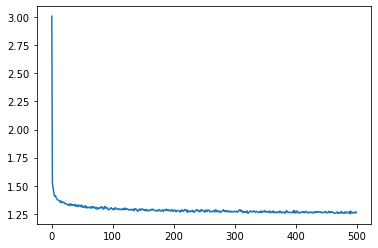

In [131]:
plt.plot(total_rgbd)